# Setup

We testing VPP at commit 2b5bc3bce6fc5d4a2bbe1342522c62f9da0efd19.

Grub cmdline parameters

```
BOOT_IMAGE=/boot/vmlinuz-5.4.0-169-generic root=UUID=c1f3b844-1efd-4741-bac3-929ffe9d6d92 ro crashkernel=auto isolcpus=8-27,36-55 iommu=pt intel_iommu=on default_hugepagesz=1G hugepagesz=1G hugepages=32 nohz_full=8-27,36-55 tsc=reliable irqaffinity=0 rcu_nocbs=8-27,36-55 rcu_nocbs_poll idle=poll rsc=reliable mce=ignore_ce audit=0 nmi_watchdog=0 skew_tick=1 nosoftlookup
```

```
unix {
  nodaemon
  interactive
  log /var/log/vpp.log
  full-coredump
  cli-listen /run/vpp/cli.sock
  # cli-listen 0.0.0.0:5002
  exec /etc/vpp/vpp_cli.conf.l2xc
}

api-trace {
  on
}

statseg {
  size 1G
}

socksvr {
  socket-name /run/vpp/api.sock
}

plugins {
  plugin default { disable }
  plugin dpdk_plugin.so { enable }
}

cpu {
  main-core 44
  corelist-workers 36
  # corelist-hqos-threads 37
}

memory {
  main-heap-size 500M
  main-heap-page-size 1G
}

dpdk {
  no-multi-seg
  no-tx-checksum-offload

  dev default {
    num-rx-desc 4096
    num-tx-desc 4096
    num-rx-queues 1
  }
  dev 0000:86:01.0 {
    name dev0
  }
  dev 0000:86:01.1 {
    name dev1
    # hqos {}
  }
}

logging {
  ## Available severity levels:
  ## emerg|alertcrit|err|warn|notice|info|debug|disabled

  default-log-level info
  default-syslog-log-level info
}

buffers {
   buffers-per-numa 256000
   default data-size 2048
   page-size default-hugepage
}

# statseg {
#    per-node-counters on
#  }
```

```
set int mac address dev0 00:00:00:01:00:01
set int mac address dev1 00:00:00:01:00:02

set interface mtu 9000 dev0
set interface mtu 9000 dev1

set interface l2 xconnect dev0 dev1
set interface l2 xconnect dev1 dev0

set interface promiscuous off dev1

set interface state dev0 up
set interface state dev1 up
````

# Experiment 1.1 Shaping accuracy

Parameters:
- Sessions: {1, 2, 4, ..., 4096}
- Flows p Session: 2
- TOS per flow: {0 (HP), 1 (LP)}
- Packet sizes: {64, 256, 512, 1500}

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker
import ast
import json
from sklearn import preprocessing
import re
from libs import read_df

In [2]:
%config IPCompleter.greedy=True
%matplotlib notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 10]

POINT_PLOT_DODGE = 0.15
sns.set(font_scale=2, style="white")

In [42]:
experiment_labels = [
    "1gbpsl1-2200",
    "2gbpsl1-2200",
    "3gbpsl1-2200",
    "4gbpsl1-2200",
    "5gbpsl1-2200",
    "6gbpsl1-2200",
    # "8192-6gbpsl1",
]

measurements = list()

for experiment in experiment_labels:
    output_dir = f"../output/vpp-flow-{experiment}"
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        call = 0

        for file in files:
            none, flows, packet_size, repeat = direc.replace(output_dir, "").split("/")

            if "vpp" in file:
                with open(
                    direc + "/" + file, "r", encoding="utf8", errors="ignore"
                ) as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])

                        if "/err/dev1-tx/Tx" in p and "2]:" in p[2] and "[0" in p[0]:
                            drops = int(p[3])

                        if (
                            "/nodes/dev1-output/vectors" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            vectors = int(p[3])

                        if (
                            "/nodes/dev1-output/calls" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            calls = int(p[3])

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = ast.literal_eval(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue

        pkt_loss = t["total"]["opackets"] - t["total"]["ipackets"]
        measurements.append(
            {
                "total_rx_L1": t["total"]["rx_bps_L1"],
                "total_tx_L1": int(t["total"]["tx_bps_L1"]),
                "total_tx_pps": int(t["total"]["tx_pps"]),
                "total_rx_pps": int(t["total"]["rx_pps"]),
                "lost_packets": pkt_loss,
                "tx_util": t["total"]["tx_util"],
                "flows": int(flows),
                "packet_size": int(packet_size),
                "misses": misses,
                "drops": drops,
                "units": repeat,
                "vectors": vectors,
                "call": calls,
                "Offered load": experiment.replace("-2200", ""),
                "experiment_int": int(experiment.replace("gbpsl1-2200", "")),
            }
        )

    measures_df = pd.DataFrame(measurements)

In [43]:
t_df = measures_df
columns = ["misses", "drops", "units"]
error_df = pd.melt(
    t_df,
    id_vars=[
        "units",
        "experiment_int",
        "packet_size",
        "flows",
        "tx_util",
        "lost_packets",
        "Offered load",
    ],
    value_vars=columns,
).rename(columns={"variable": "Error Type", "value": "Errors"})
error_df = error_df.assign(
    normalized_errors=error_df["Errors"] / error_df["lost_packets"] * 100
).replace(to_replace=np.nan, value=0)

KeyError: "The following 'id_vars' are not present in the DataFrame: ['units', 'experiment_int', 'packet_size', 'flows', 'tx_util', 'lost_packets', 'Offered load']"

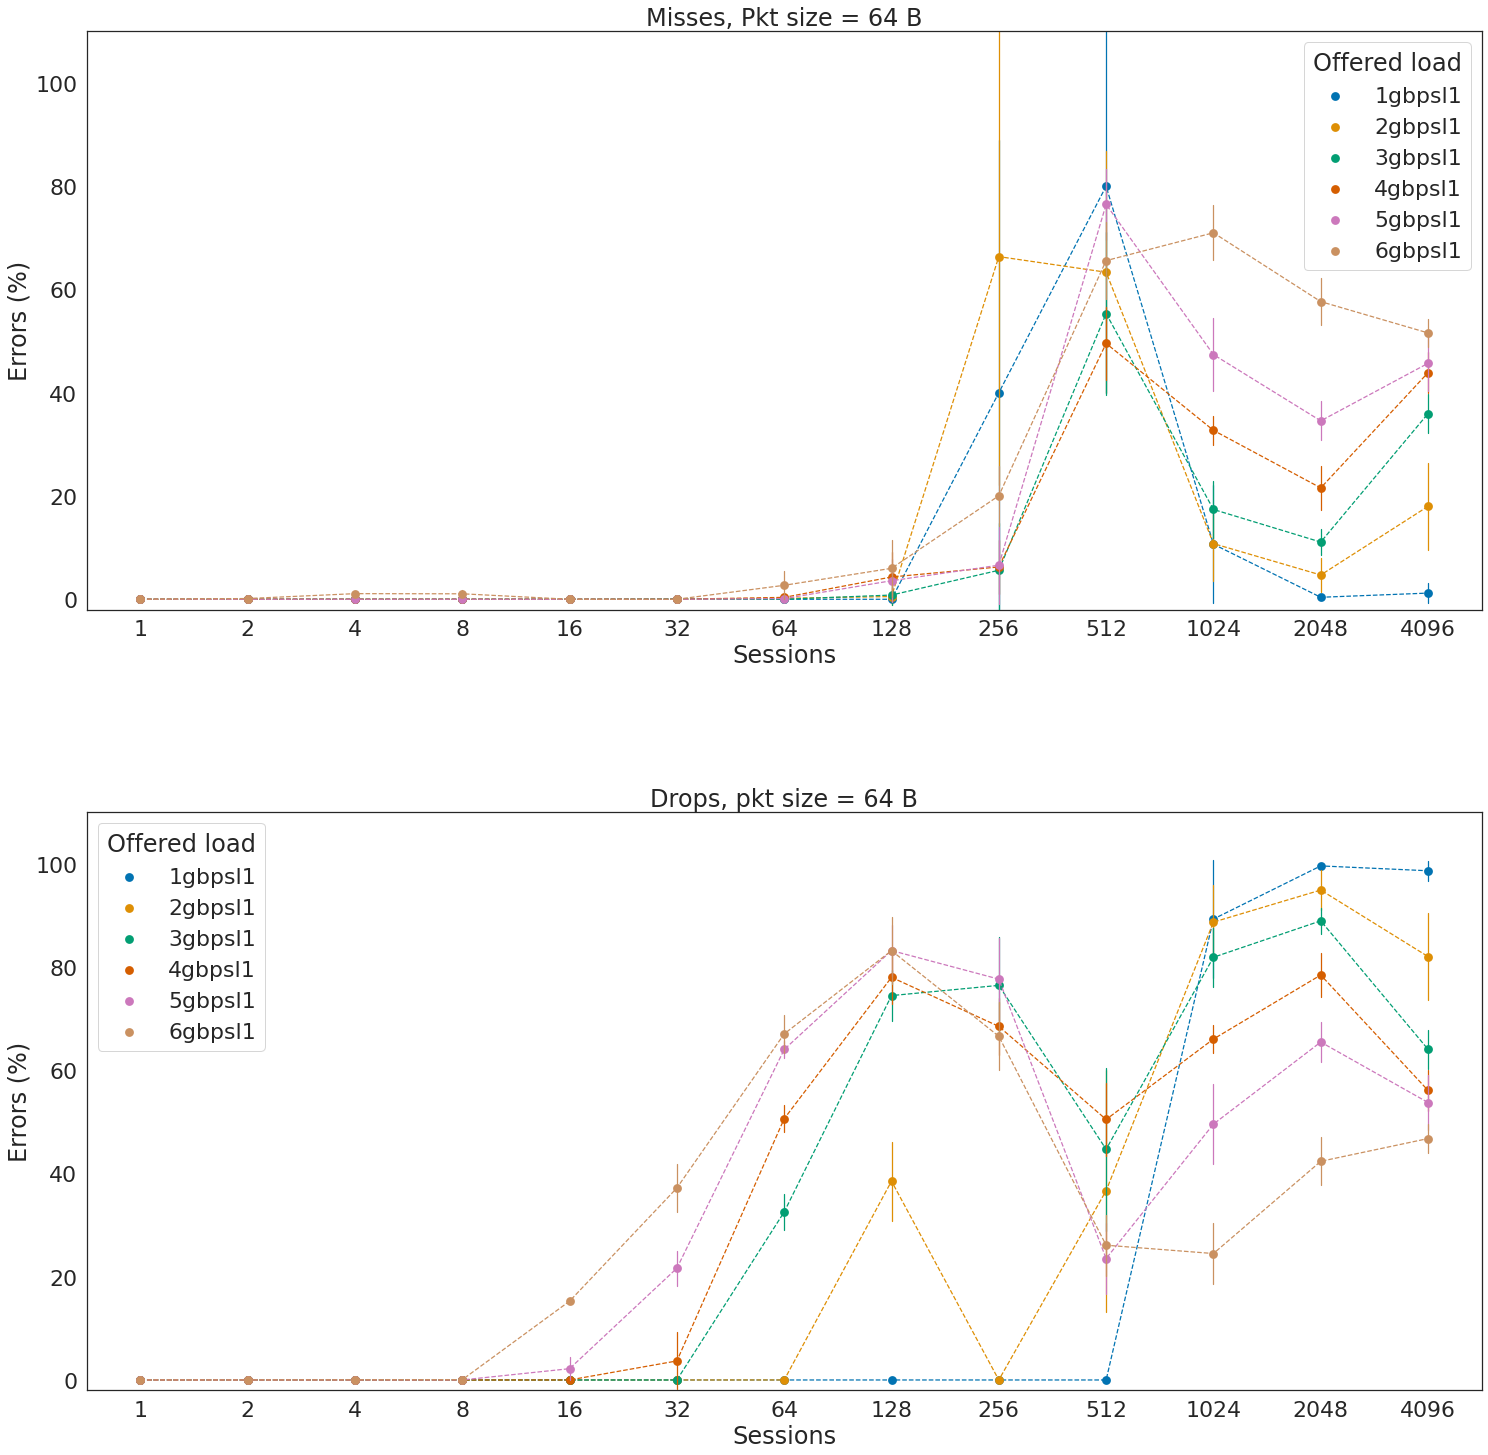

In [12]:
%matplotlib inline
fig, (ax2, ax3) = plt.subplots(nrows=2, ncols=1, figsize=(25, 25))

PKT_SIZE = 64
p_df = error_df[error_df["packet_size"] == PKT_SIZE]

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "misses"],
    x="flows",
    y='normalized_errors',
    hue="Offered load",
    units="units",
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    title="Misses, Pkt size = 64 B",
    ylim=[-2, 110],
)
plt.setp(fig.lines, linewidth=1.25)


p_df = error_df[error_df["packet_size"] == 64]
fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "drops"],
    x="flows",
    y='normalized_errors',
    hue="Offered load",
    units="units",
    ax=ax3,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    title="Drops, pkt size = 64 B",
    ylim=[-2, 110],
)
plt.setp(fig.lines, linewidth=1.25)

plt.subplots_adjust(hspace=0.35)

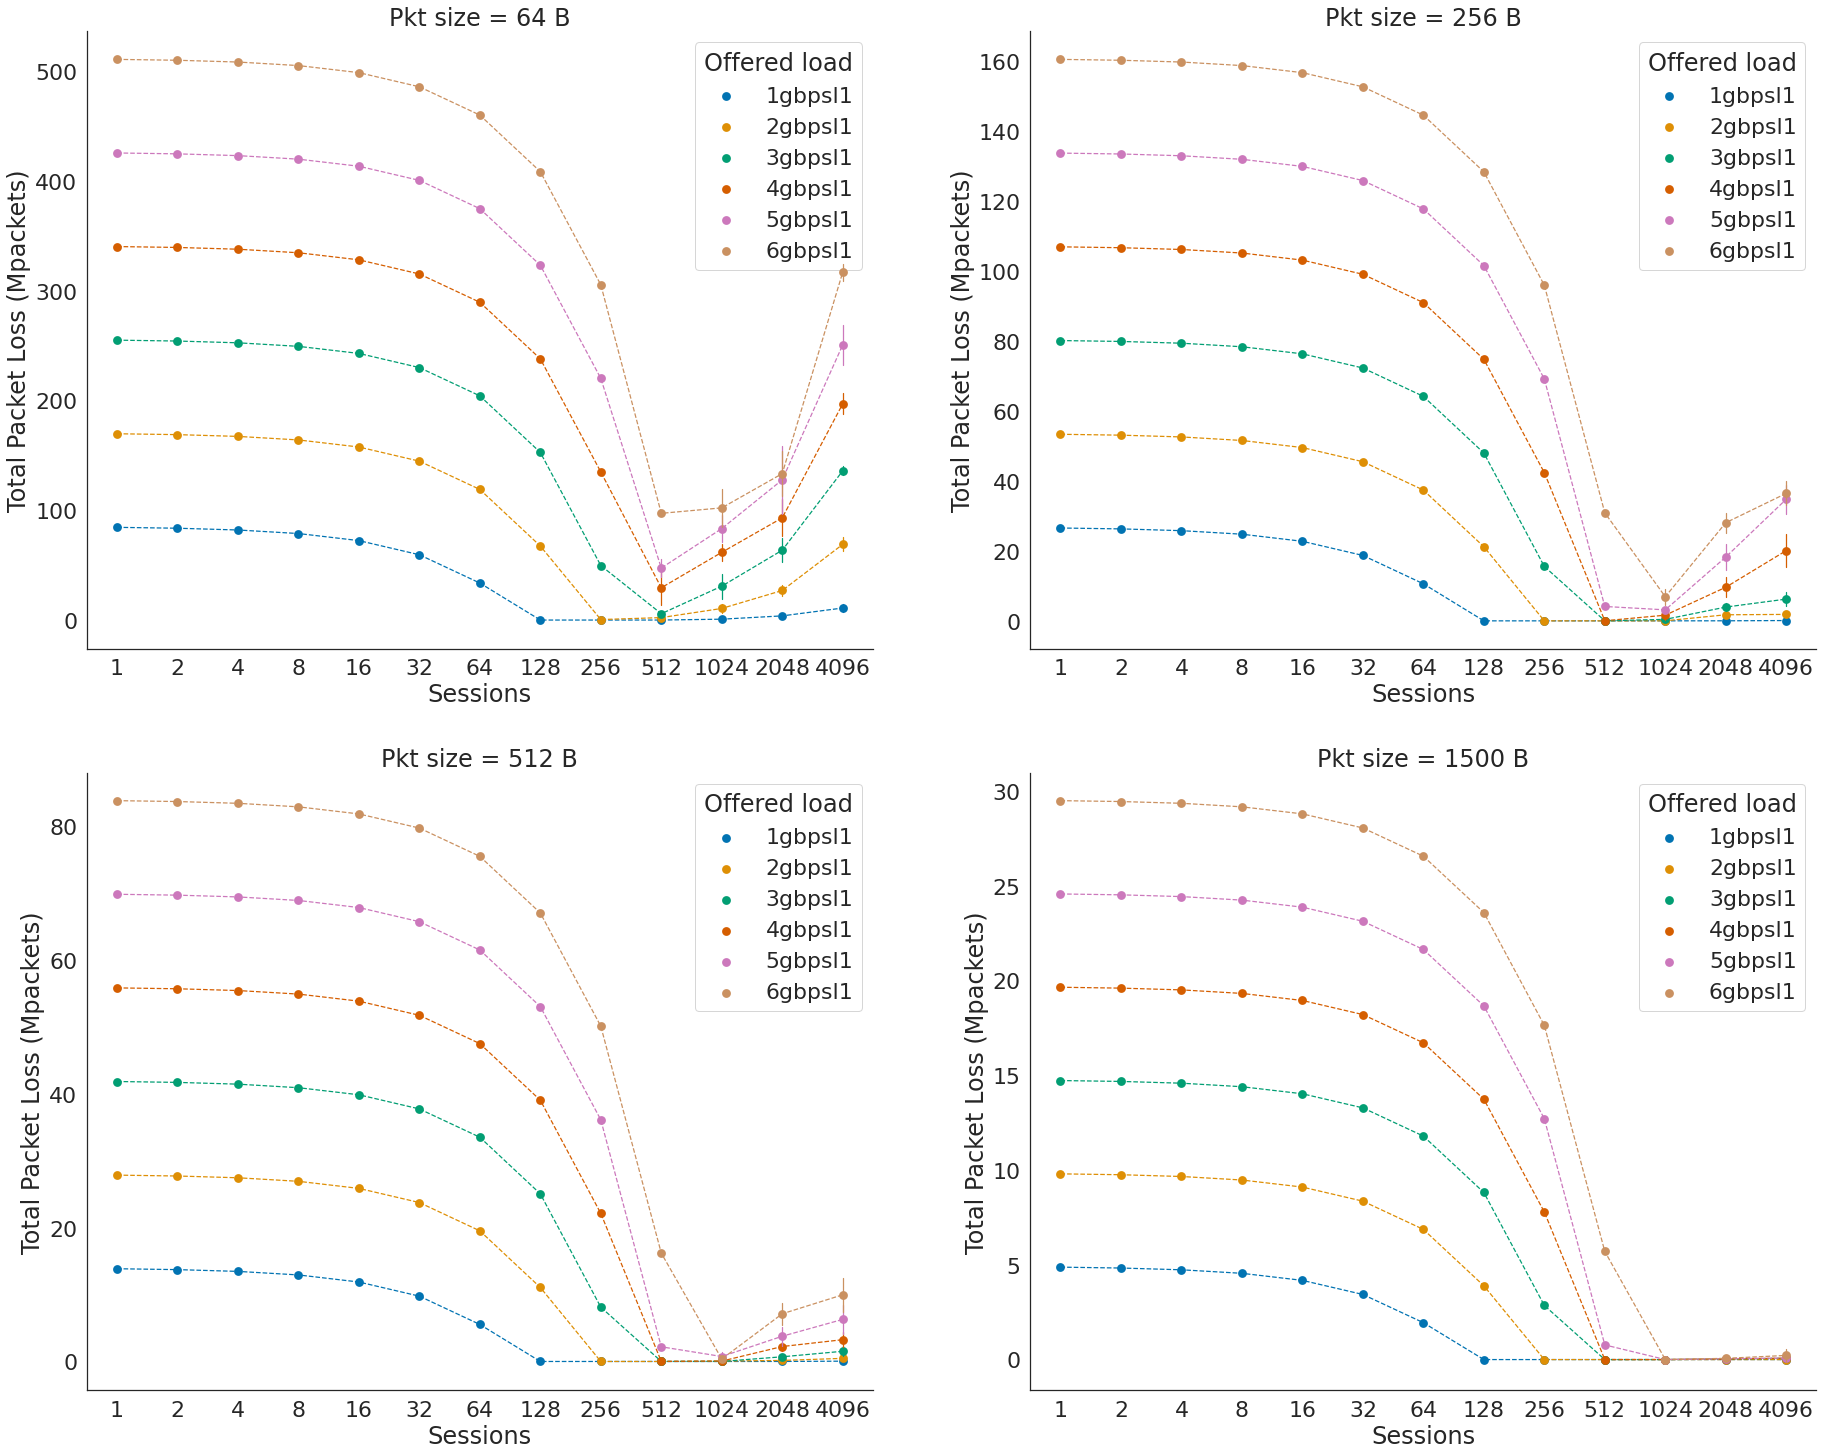

In [16]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(31, 25))

fig = sns.pointplot(
    data=measures_df[measures_df["packet_size"] == 64],
    x="flows",
    y=measures_df["lost_packets"] / (10**6),
    hue="Offered load",
    units="units",
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Packet Loss (Mpackets)",
    xlabel="Sessions",
    title="Pkt size = 64 B",
)
plt.setp(fig.lines, linewidth=1.25)


fig = sns.pointplot(
    data=measures_df[measures_df["packet_size"] == 256],
    x="flows",
    y=measures_df["lost_packets"] / (10**6),
    hue="Offered load",
    units="units",
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Total Packet Loss (Mpackets)",
    xlabel="Sessions",
    title="Pkt size = 256 B",
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=measures_df[measures_df["packet_size"] == 512],
    x="flows",
    y=measures_df["lost_packets"] / (10**6),
    hue="Offered load",
    units="units",
    ax=ax3,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    # dodge = 0.5,
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500]g = sns.factorplot(x="time", y="pulse", hue="kind", data=exercise, scale=.5)
)

ax3.set(
    ylabel="Total Packet Loss (Mpackets)",
    xlabel="Sessions",
    title="Pkt size = 512 B",
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=measures_df[measures_df["packet_size"] == 1500],
    x="flows",
    y=measures_df["lost_packets"] / (10**6),
    hue="Offered load",
    units="units",
    ax=ax4,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    # dodge = 0.5,
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)

ax4.set(
    ylabel="Total Packet Loss (Mpackets)",
    xlabel="Sessions",
    title="Pkt size = 1500 B",
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

# fig.get_figure().savefig("../output_figures/vpp-experiments/pktloss_2200.pdf")

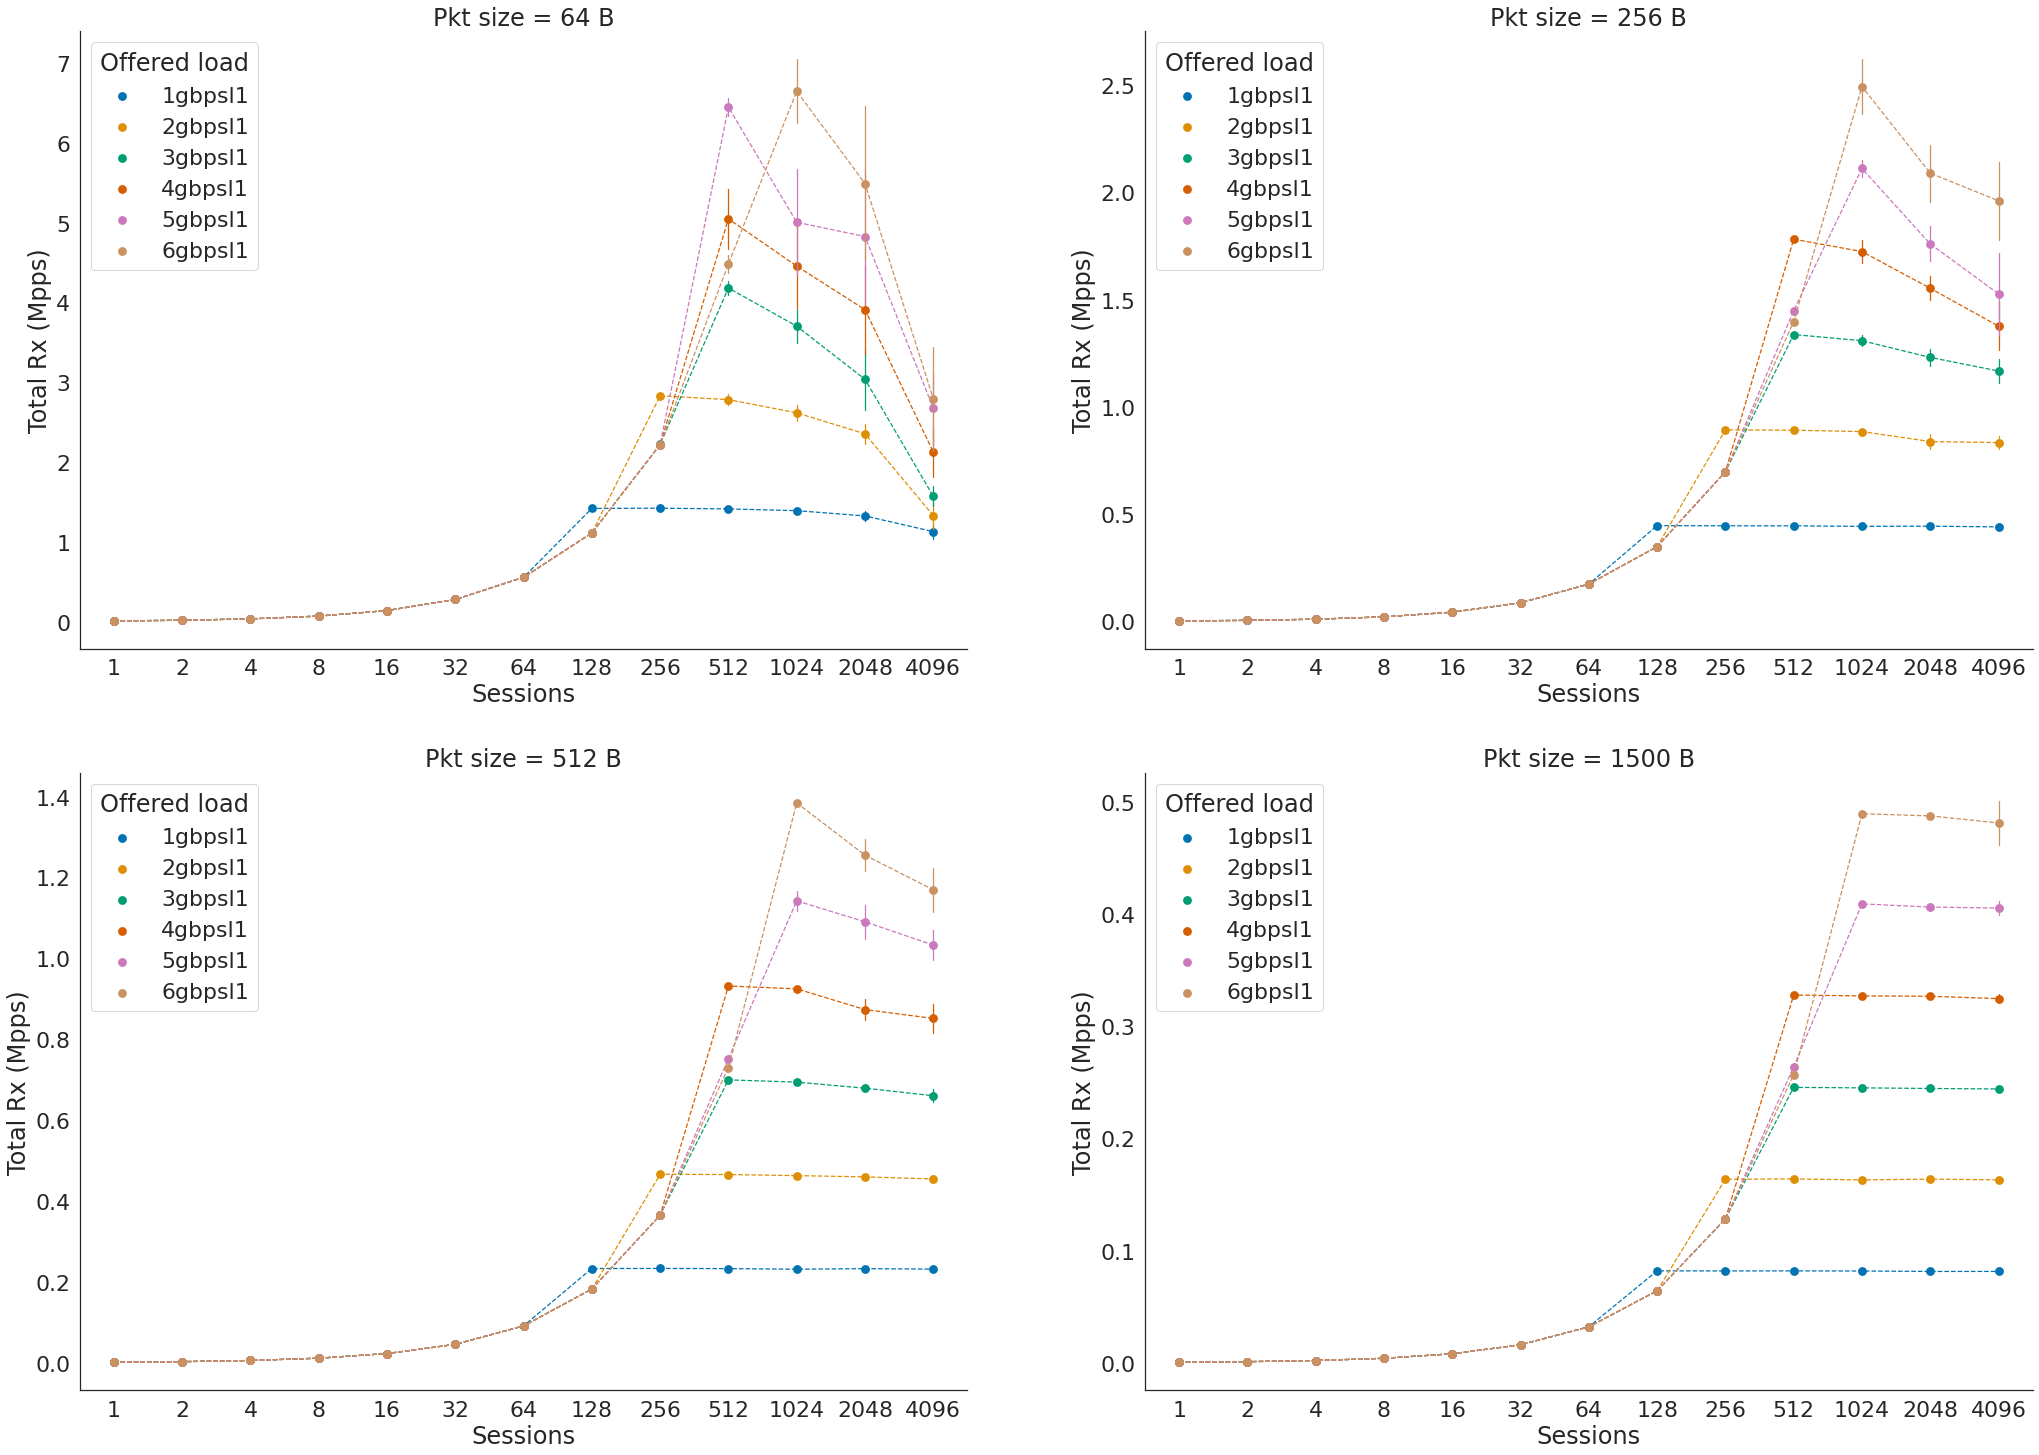

In [17]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 25))

fig = sns.pointplot(
    data=measures_df[measures_df["packet_size"] == 64],
    x="flows",
    y = measures_df['total_rx_pps']/(10**6),
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="Offered load",
    units="units",
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Sessions",
    title="Pkt size = 64 B",
)
plt.setp(fig.lines, linewidth=1.25)
# plt.legend(title = "Total offered load")


fig = sns.pointplot(
    data=measures_df[measures_df["packet_size"] == 256],
    x="flows",
    y = measures_df['total_rx_pps']/(10**6),
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="Offered load",
    units="units",
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Sessions",
    title="Pkt size = 256 B",
    # ylim = [-0.1, 3],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=measures_df[measures_df["packet_size"] == 512],
    x="flows",
    y = measures_df['total_rx_pps']/(10**6),
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="Offered load",
    units="units",
    ax=ax3,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    # dodge = 0.5,
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500]g = sns.factorplot(x="time", y="pulse", hue="kind", data=exercise, scale=.5)
)

ax3.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Sessions",
    title="Pkt size = 512 B",
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=measures_df[measures_df["packet_size"] == 1500],
    x="flows",
    y = measures_df['total_rx_pps']/(10**6),
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="Offered load",
    units="units",
    ax=ax4,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    # dodge = 0.5,
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)

ax4.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Sessions",
    title="Pkt size = 1500 B",
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

# fig.get_figure().savefig("rx_load_pkt_size_2200_bps.png")

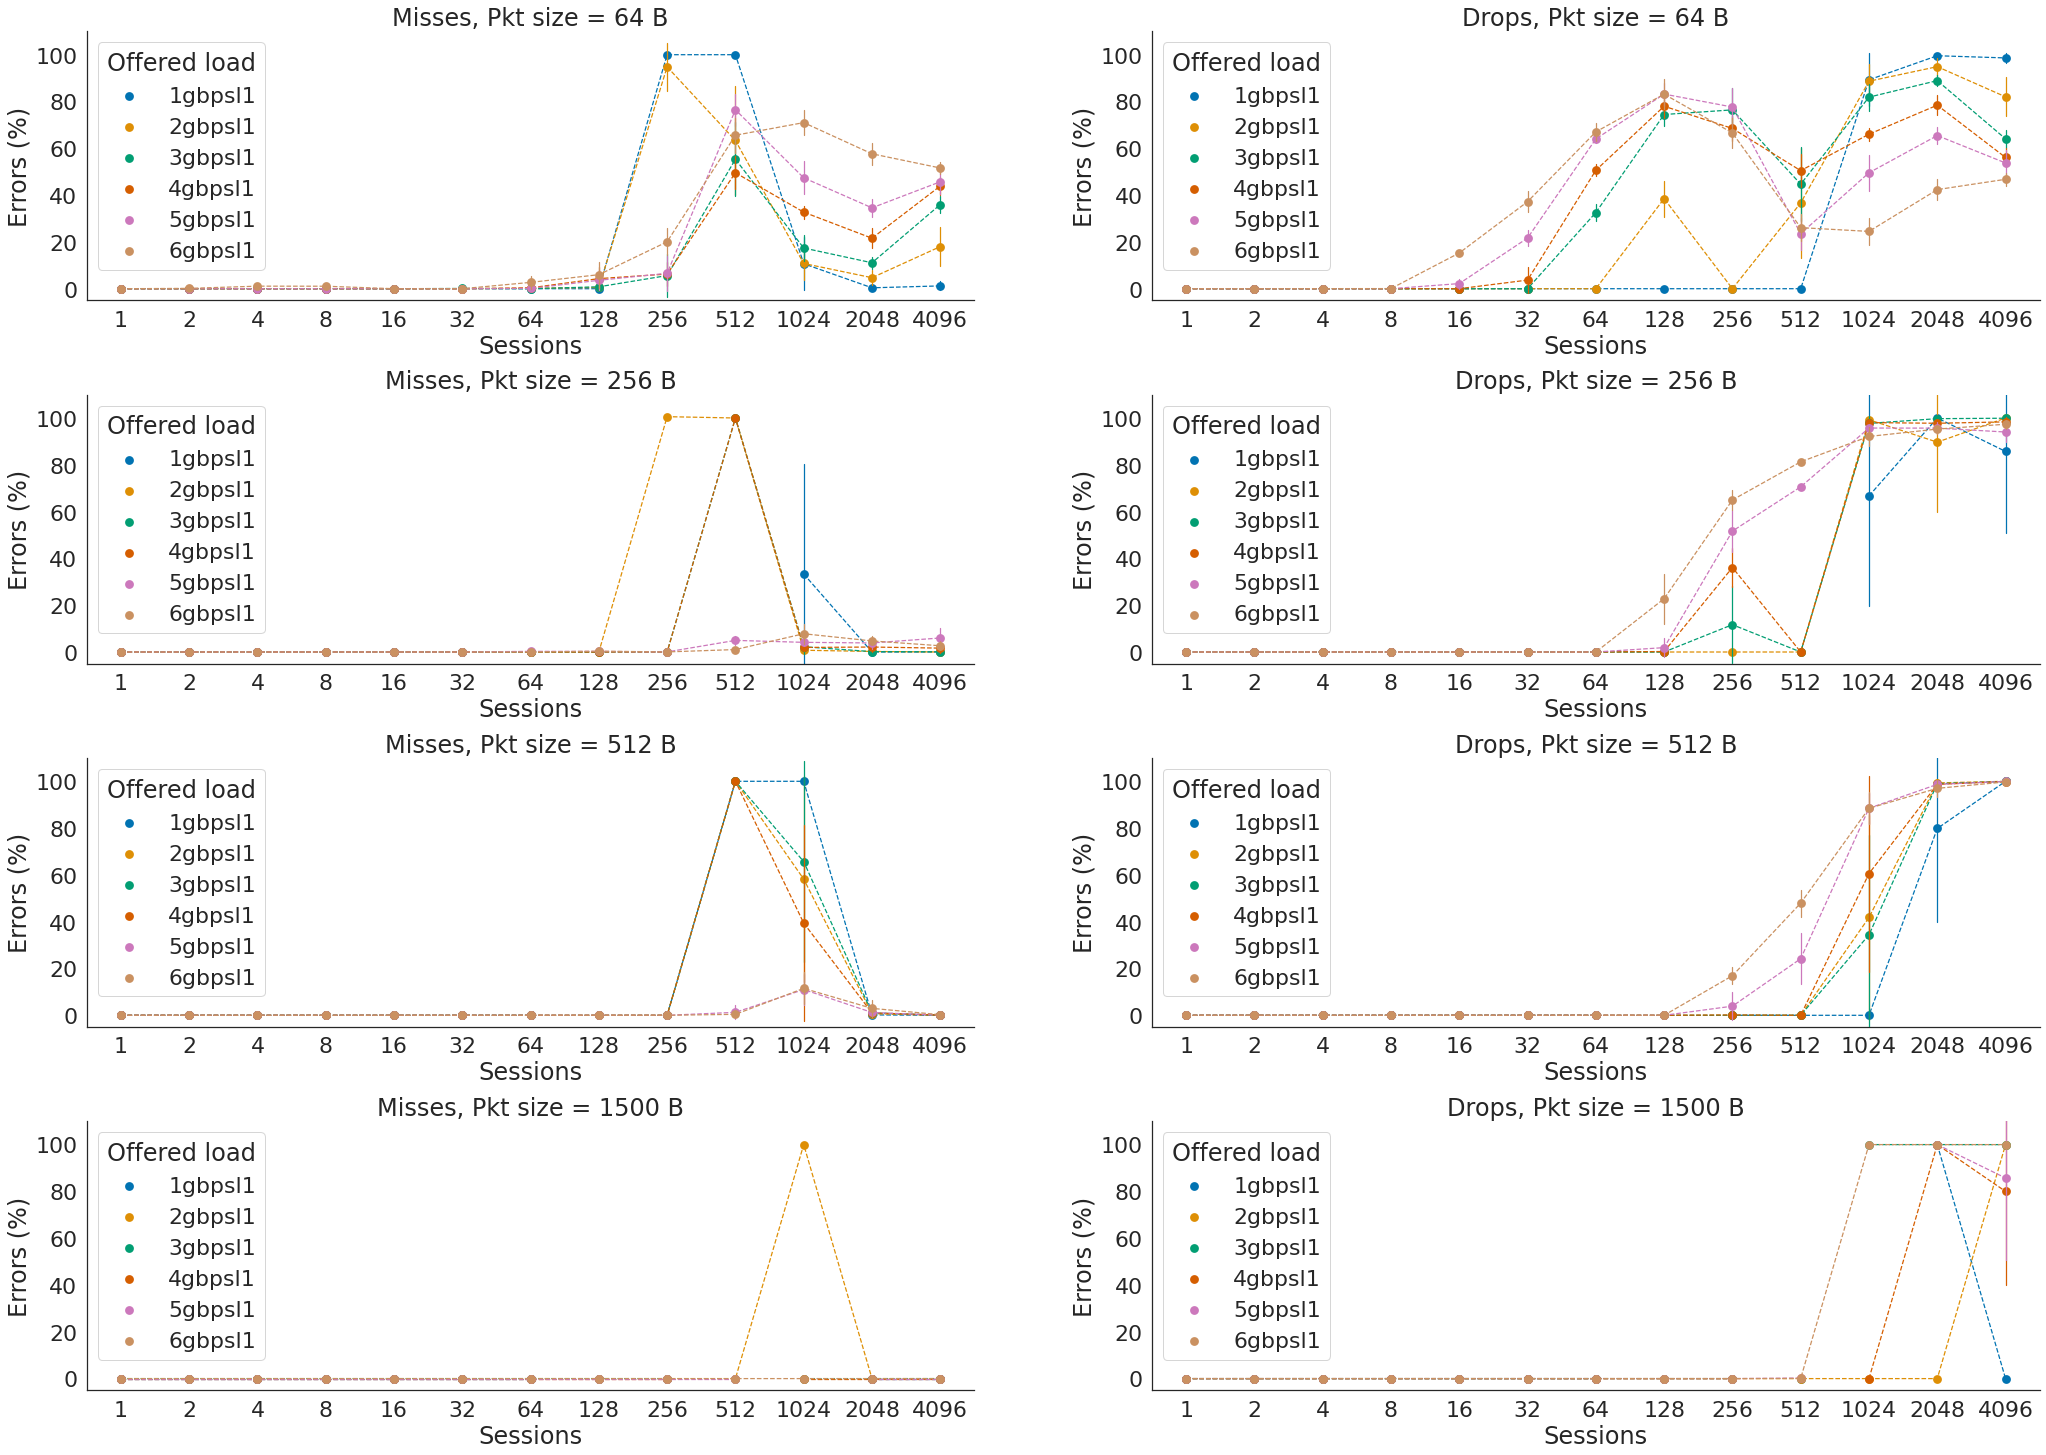

In [39]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(
    nrows=4, ncols=2, figsize=(35, 25)
)

p_df = error_df[error_df["packet_size"] == 64]

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "misses"],
    x="flows",
    y='normalized_errors',
    hue="Offered load",
    units="units",
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax1.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title="Misses, Pkt size = 64 B",
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "drops"],
    x="flows",
    y='normalized_errors',
    hue="Offered load",
    units="units",
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax2.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title="Drops, Pkt size = 64 B",
    # ylim = [-0.1, 2],
)
plt.setp(fig.lines, linewidth=1.25)

p_df = error_df[error_df["packet_size"] == 256]

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "misses"],
    x="flows",
    y='normalized_errors',
    hue="Offered load",
    units="units",
    ax=ax3,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax3.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title="Misses, Pkt size = 256 B",
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "drops"],
    x="flows",
    y='normalized_errors',
    hue="Offered load",
    units="units",
    ax=ax4,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax4.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title="Drops, Pkt size = 256 B",
)
plt.setp(fig.lines, linewidth=1.25)

p_df = error_df[error_df["packet_size"] == 512]

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "misses"],
    x="flows",
    y='normalized_errors',
    hue="Offered load",
    units="units",
    ax=ax5,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax5.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title="Misses, Pkt size = 512 B",
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "drops"],
    x="flows",
    y='normalized_errors',
    hue="Offered load",
    units="units",
    ax=ax6,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax6.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title="Drops, Pkt size = 512 B",
)
plt.setp(fig.lines, linewidth=1.25)

p_df = error_df[error_df["packet_size"] == 1500]

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "misses"],
    x="flows",
    y='normalized_errors',
    hue="Offered load",
    units="units",
    ax=ax7,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax7.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title="Misses, Pkt size = 1500 B",
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "drops"],
    x="flows",
    y='normalized_errors',
    hue="Offered load",
    units="units",
    ax=ax8,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax8.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title="Drops, Pkt size = 1500 B",
)
plt.setp(fig.lines, linewidth=1.25)

plt.subplots_adjust(hspace=0.35)

sns.despine()

# fig.get_figure().savefig("errors_pkt_size_2200.png")

# Experiment 1.2 CPU Frequency changes

Parameters:
- CPU Freq: {1000, 2200, 3000, 4000}
- Sessions: {1, 2, 4, ..., 4096}
- Flows p Session: 2
- TOS per flow: {0 (HP), 1 (LP)}2
- Packet sizes: {64, 256, 512, 1500}

In [9]:
experiment_labels = [
    "1gbpsl1-3000",
    "1gbpsl1-2200",
    "1gbpsl1-1000",
    "2gbpsl1-3000",
    "2gbpsl1-2200",
    "2gbpsl1-1000",
    "3gbpsl1-2200",
    "3gbpsl1-3000",
    "3gbpsl1-1000",
    "4gbpsl1-3000",
    "4gbpsl1-2200",
    "4gbpsl1-1000",
    "5gbpsl1-3000",
    "5gbpsl1-2200",
    "5gbpsl1-1000",
    "6gbpsl1-3000",
    "6gbpsl1-2200",
    "6gbpsl1-1000",
    # "8192-6gbpsl1",
]

measurements = list()

for experiment in experiment_labels:
    output_dir = f"../output/vpp-flow-{experiment}"
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        call = 0

        frequency = experiment.split("-")[1]
        target_load = experiment.split("-")[0]

        for file in files:
            none, flows, packet_size, repeat = direc.replace(output_dir, "").split("/")

            if "vpp" in file:
                with open(
                    direc + "/" + file, "r", encoding="utf8", errors="ignore"
                ) as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])

                        if "/err/dev1-tx/Tx" in p and "2]:" in p[2] and "[0" in p[0]:
                            drops = int(p[3])

                        if (
                            "/nodes/dev1-output/vectors" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            vectors = int(p[3])

                        if (
                            "/nodes/dev1-output/calls" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            calls = int(p[3])

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = ast.literal_eval(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue

        pkt_loss = t["total"]["opackets"] - t["total"]["ipackets"]
        measurements.append(
            {
                "total_rx_L1": t["total"]["rx_bps_L1"],
                "total_tx_L1": int(t["total"]["tx_bps_L1"]),
                "total_tx_pps": int(t["total"]["tx_pps"]),
                "total_rx_pps": int(t["total"]["rx_pps"]),
                "lost_packets": pkt_loss,
                "tx_util": t["total"]["tx_util"],
                "flows": int(flows),
                "packet_size": int(packet_size),
                "misses": misses,
                "drops": drops,
                "misses_normalized": misses / (1 if pkt_loss == 0 else pkt_loss),
                "drops_normalized": drops / (1 if pkt_loss == 0 else pkt_loss),
                "units": repeat,
                "vectors": vectors,
                "call": calls,
                "Offered load": target_load,
                "frequency": int(frequency),
            }
        )

    multicore_measures_df = pd.DataFrame(measurements)

In [10]:
t_df = multicore_measures_df
columns = ["misses", "drops", "units"]
# columns = ['misses_normalized', 'drops_normalized']
error_df = pd.melt(
    t_df,
    id_vars=[
        "units",
        "frequency",
        "packet_size",
        "flows",
        "tx_util",
        "lost_packets",
        "Offered load",
    ],
    value_vars=columns,
).rename(columns={"variable": "Error Type", "value": "Errors"})

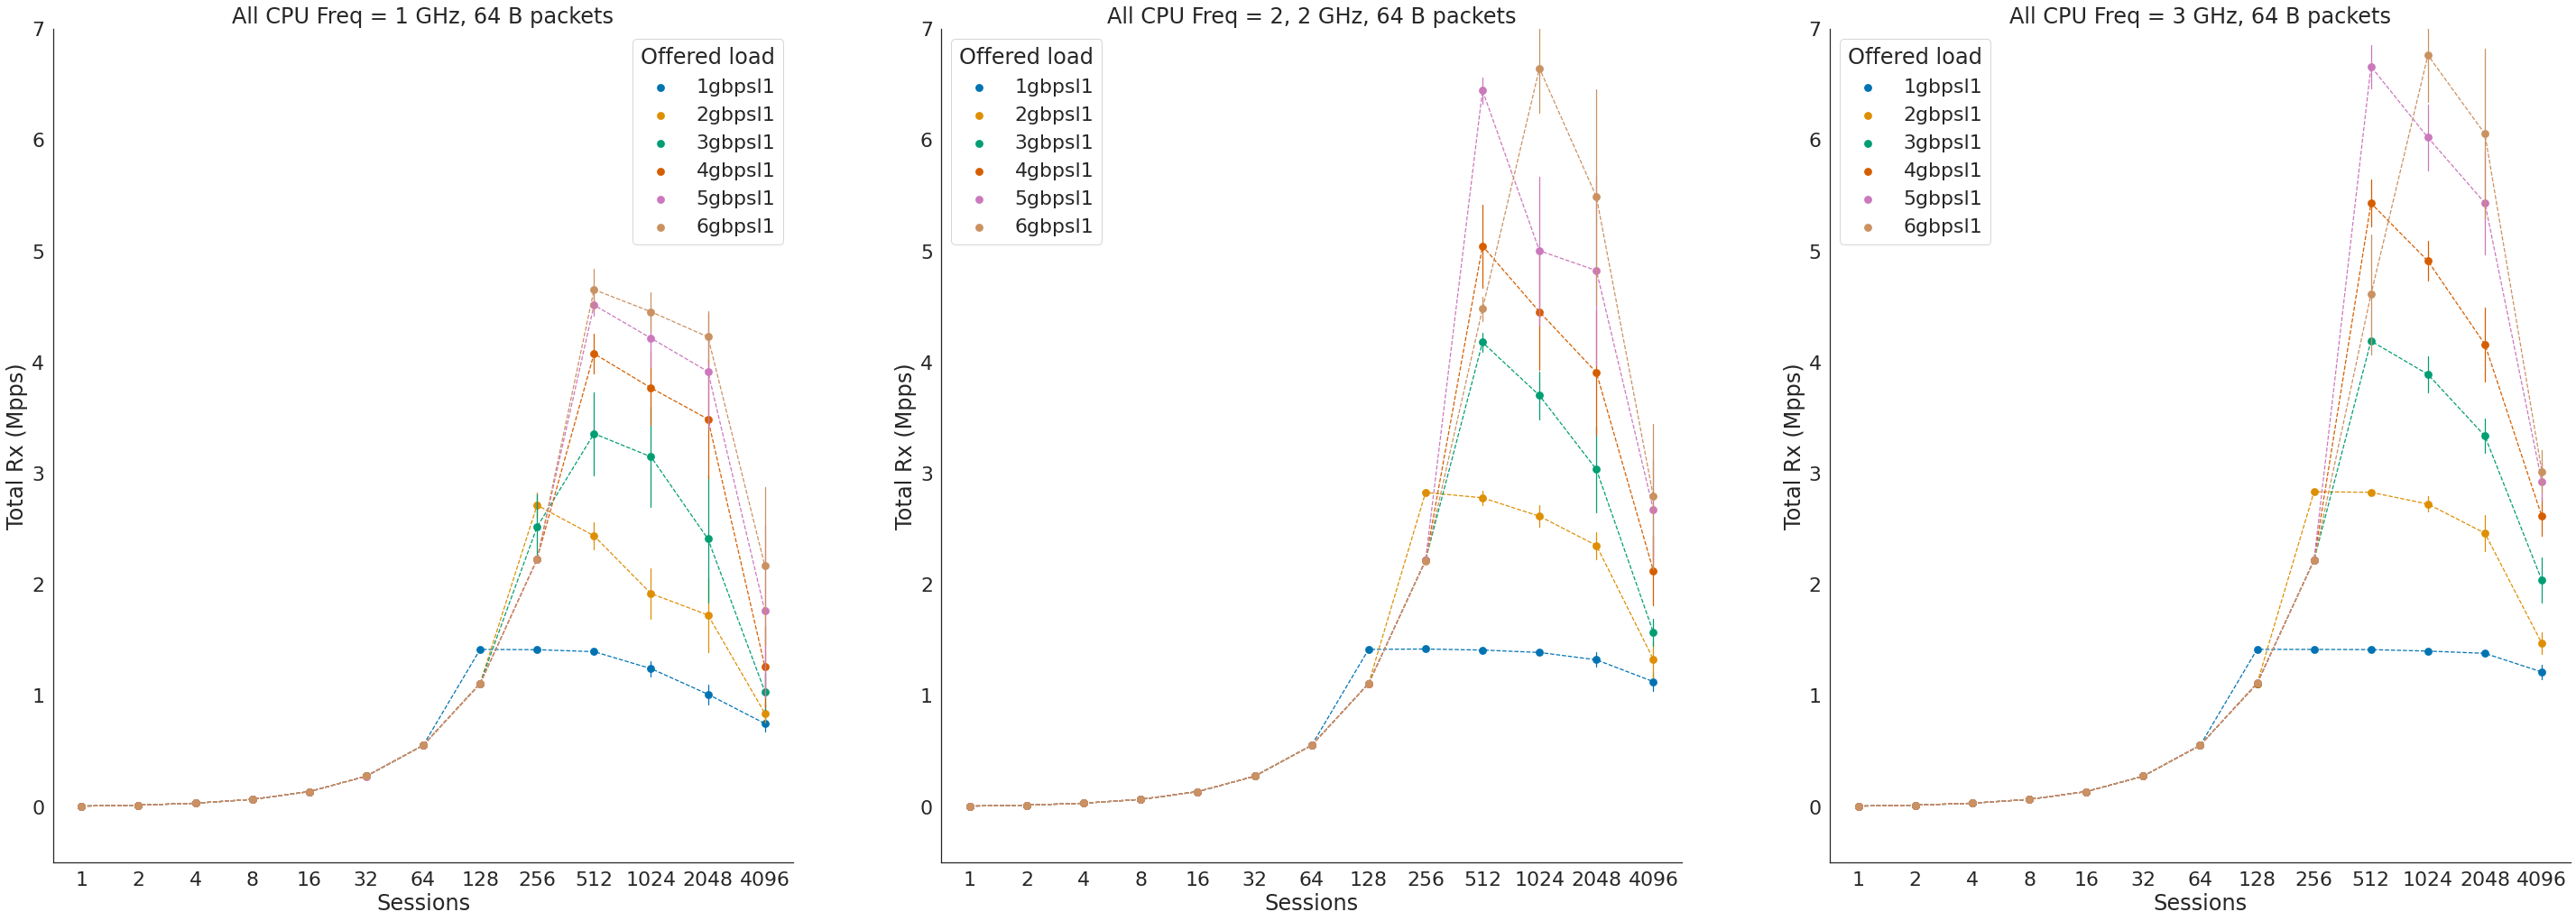

In [11]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(50, 17))

t_df = multicore_measures_df[multicore_measures_df["packet_size"] == 64]

fig = sns.pointplot(
    data=t_df[t_df["frequency"] == 1000],
    x="flows",
    y=multicore_measures_df["total_rx_pps"] / (10**6),
    hue="Offered load",
    units="units",
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Sessions",
    ylim=[-0.5, 7],
    title="All CPU Freq = 1 GHz, 64 B packets",
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=t_df[t_df["frequency"] == 2200],
    x="flows",
    y=multicore_measures_df["total_rx_pps"] / (10**6),
    hue="Offered load",
    units="units",
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Sessions",
    ylim=[-0.5, 7],
    title="All CPU Freq = 2, 2 GHz, 64 B packets",
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=t_df[t_df["frequency"] == 3000],
    x="flows",
    y=multicore_measures_df["total_rx_pps"] / (10**6),
    hue="Offered load",
    units="units",
    ax=ax3,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Sessions",
    title="All CPU Freq = 3 GHz, 64 B packets",
    ylim=[-0.5, 7],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

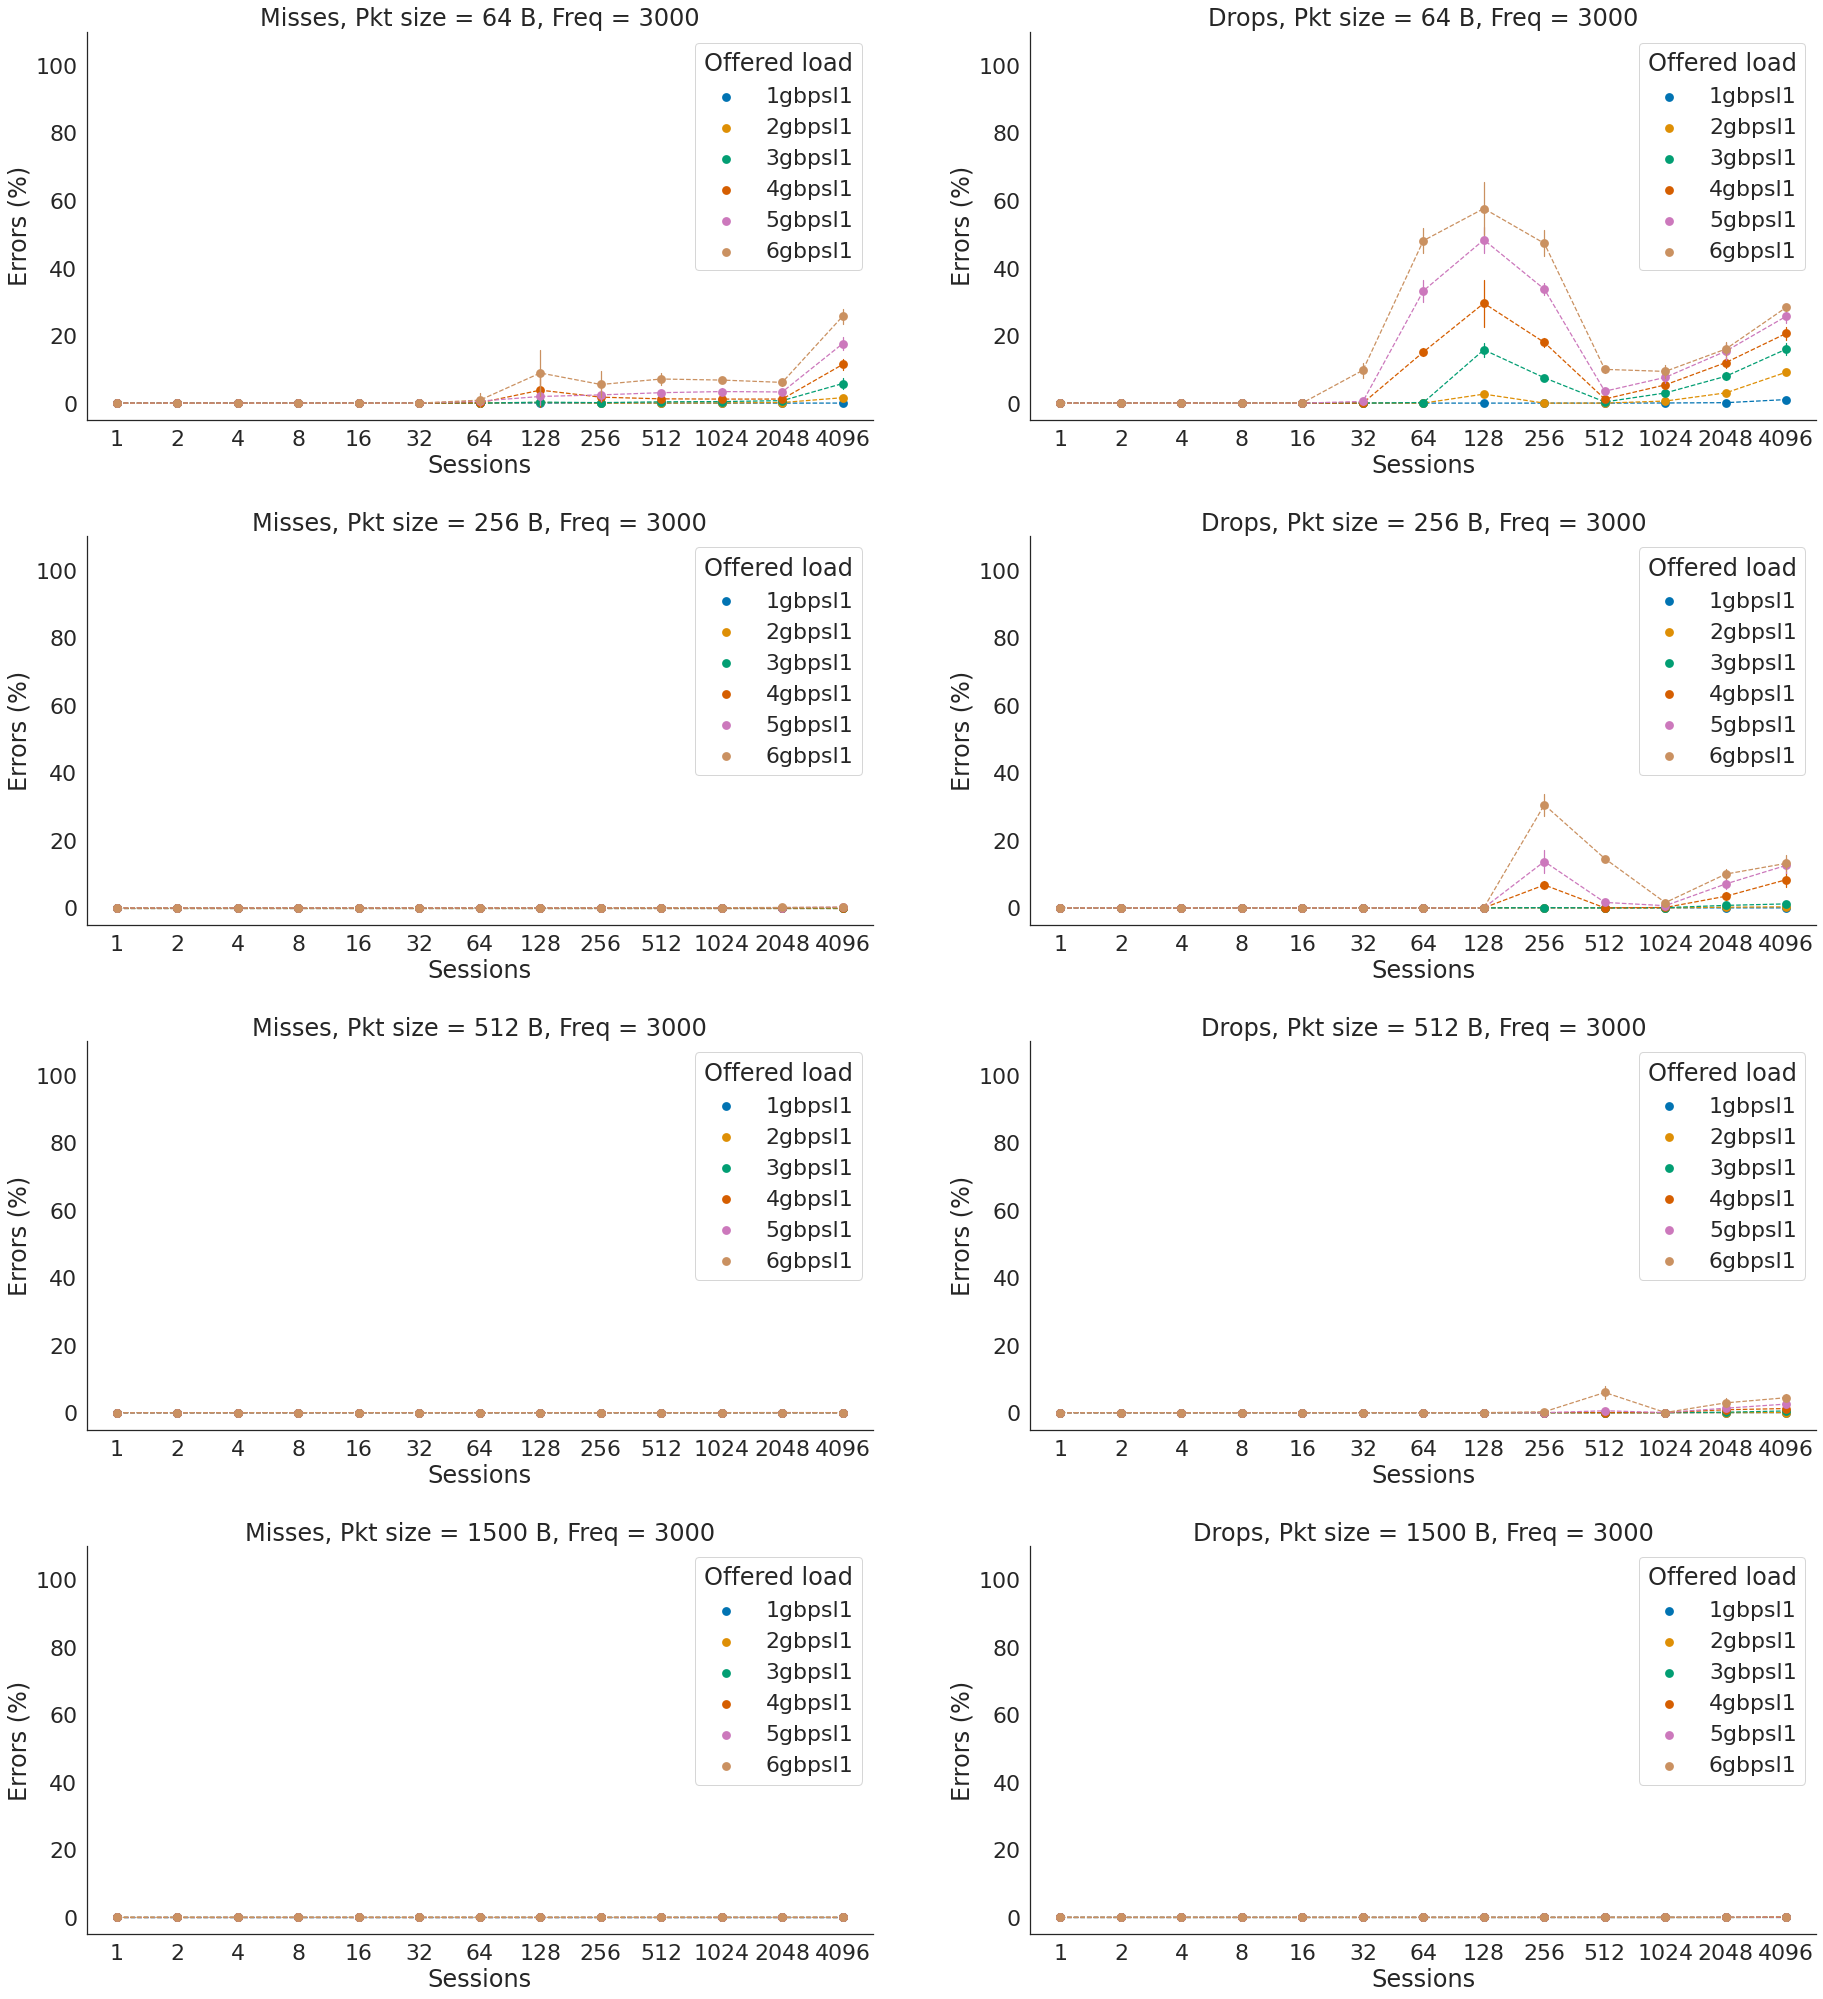

In [12]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(
    nrows=4, ncols=2, figsize=(31, 35)
)

FREQ = 3000

PKT_SIZE = 64
p_df = error_df[error_df["packet_size"] == PKT_SIZE]
p_df = p_df[p_df["frequency"] == FREQ]

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "misses"],
    x="flows",
    y=(p_df["Errors"] / max(p_df["lost_packets"])) * 100,
    hue="Offered load",
    units="units",
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax1.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Misses, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "drops"],
    x="flows",
    y=(p_df["Errors"] / max(p_df["lost_packets"])) * 100,
    hue="Offered load",
    units="units",
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax2.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Drops, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
    # ylim = [-0.1, 2],
)
plt.setp(fig.lines, linewidth=1.25)

PKT_SIZE = 256
p_df = error_df[error_df["packet_size"] == PKT_SIZE]
p_df = p_df[p_df["frequency"] == FREQ]

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "misses"],
    x="flows",
    y=(p_df["Errors"] / max(p_df["lost_packets"])) * 100,
    hue="Offered load",
    units="units",
    ax=ax3,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax3.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Misses, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "drops"],
    x="flows",
    y=(p_df["Errors"] / max(p_df["lost_packets"])) * 100,
    hue="Offered load",
    units="units",
    ax=ax4,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax4.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Drops, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
)
plt.setp(fig.lines, linewidth=1.25)

PKT_SIZE = 512
p_df = error_df[error_df["packet_size"] == PKT_SIZE]
p_df = p_df[p_df["frequency"] == FREQ]

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "misses"],
    x="flows",
    y=(p_df["Errors"] / max(p_df["lost_packets"])) * 100,
    hue="Offered load",
    units="units",
    ax=ax5,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax5.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Misses, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "drops"],
    x="flows",
    y=(p_df["Errors"] / max(p_df["lost_packets"])) * 100,
    hue="Offered load",
    units="units",
    ax=ax6,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax6.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Drops, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
)
plt.setp(fig.lines, linewidth=1.25)

PKT_SIZE = 1500
p_df = error_df[error_df["packet_size"] == PKT_SIZE]
p_df = p_df[p_df["frequency"] == FREQ]

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "misses"],
    x="flows",
    y=(p_df["Errors"] / max(p_df["lost_packets"])) * 100,
    hue="Offered load",
    units="units",
    ax=ax7,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax7.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Misses, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "drops"],
    x="flows",
    y=(p_df["Errors"] / max(p_df["lost_packets"])) * 100,
    hue="Offered load",
    units="units",
    ax=ax8,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax8.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Drops, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
)
plt.setp(fig.lines, linewidth=1.25)

plt.subplots_adjust(hspace=0.3)

sns.despine()

# fig.get_figure().savefig(f"../output_figures/{FREQ}_misses_drops.pdf")

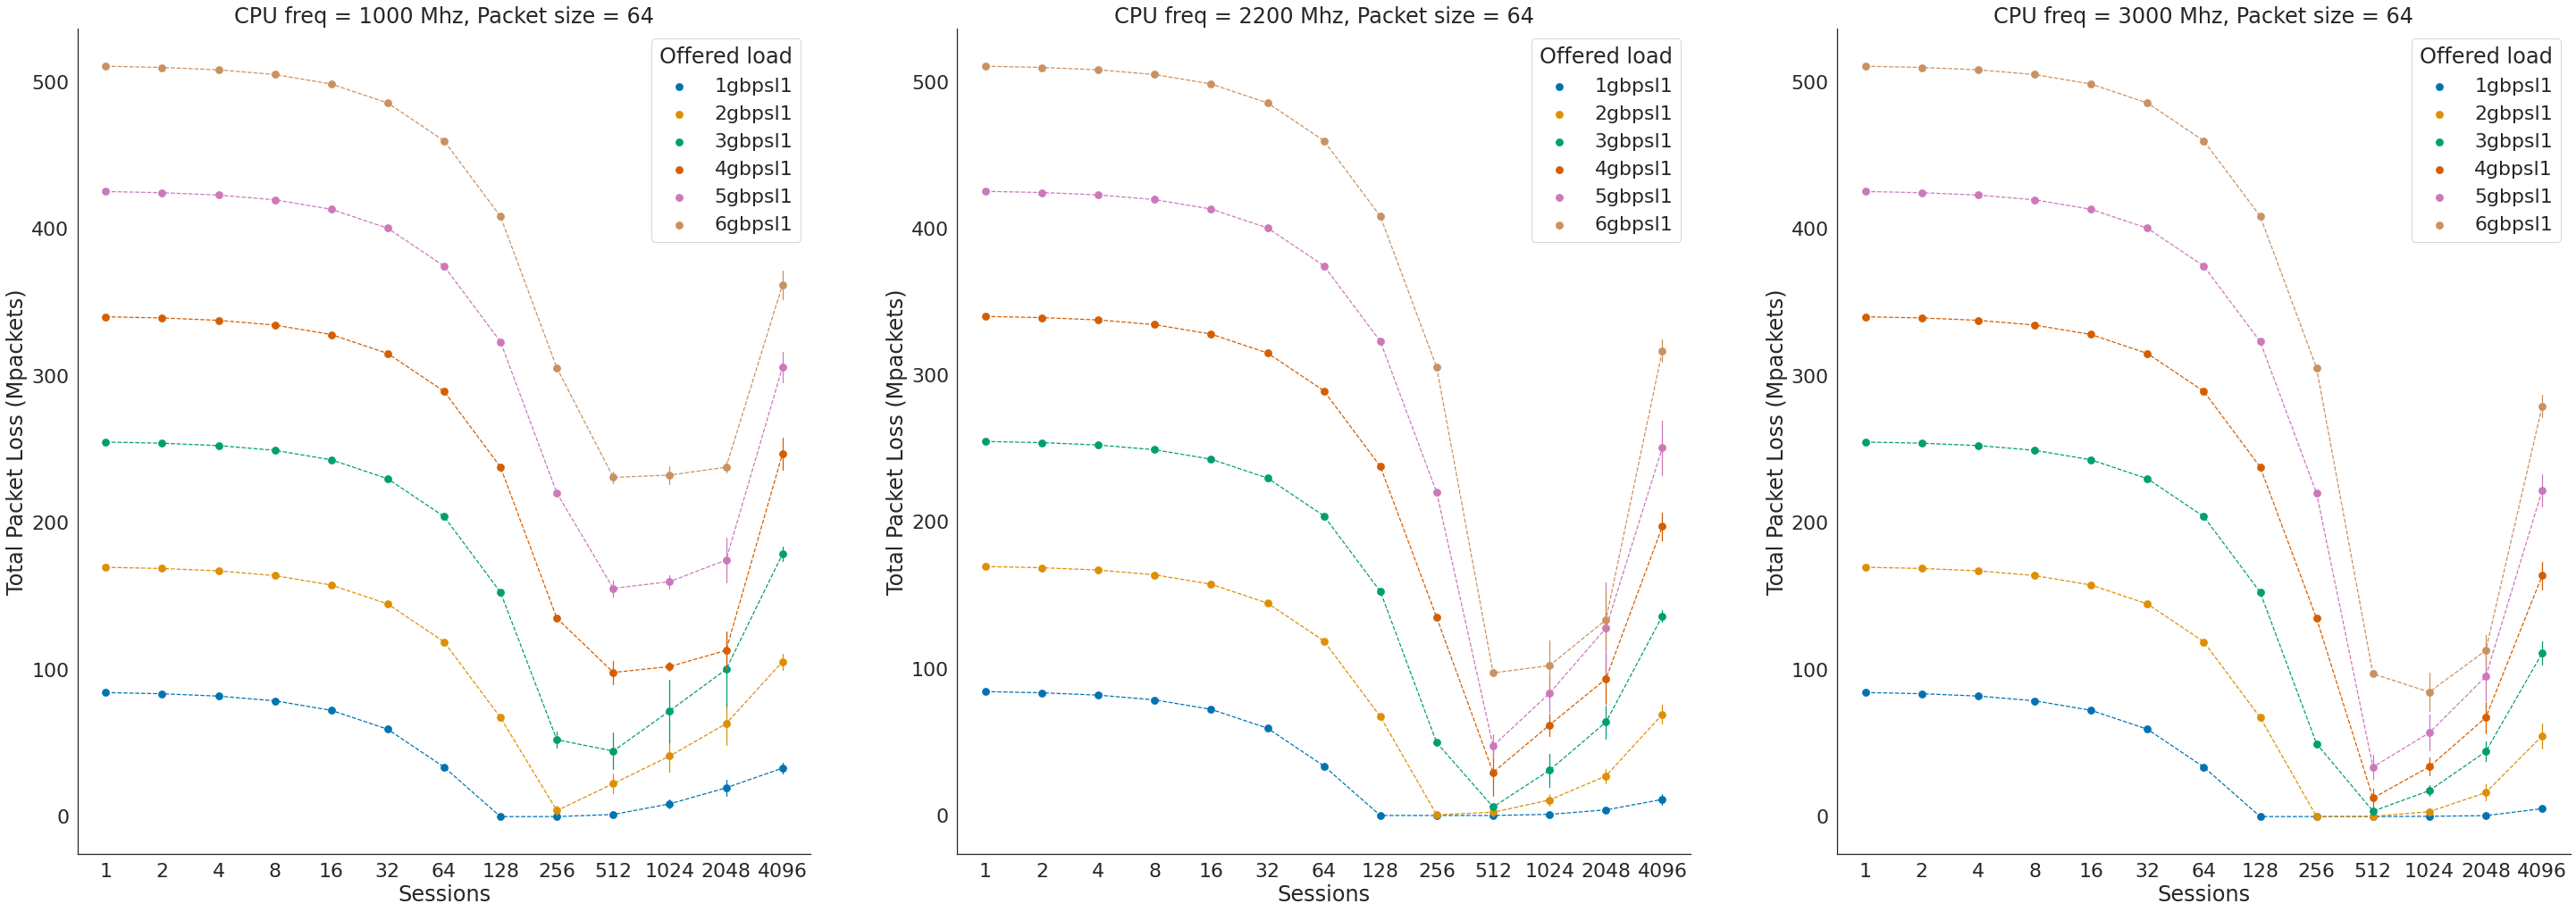

In [13]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(50, 17))

PKT_SIZE = 64

p_df = error_df[error_df["packet_size"] == PKT_SIZE]

FREQ = 1000
fig = sns.pointplot(
    data=p_df[p_df["frequency"] == FREQ],
    x="flows",
    y=p_df["lost_packets"] / (10**6),
    hue="Offered load",
    units="units",
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Packet Loss (Mpackets)",
    xlabel="Sessions",
    title=f"CPU freq = {FREQ} Mhz, Packet size = {PKT_SIZE}",
)
plt.setp(fig.lines, linewidth=1.25)

FREQ = 2200
fig = sns.pointplot(
    data=p_df[p_df["frequency"] == FREQ],
    x="flows",
    y=p_df["lost_packets"] / (10**6),
    hue="Offered load",
    units="units",
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Total Packet Loss (Mpackets)",
    xlabel="Sessions",
    title=f"CPU freq = {FREQ} Mhz, Packet size = {PKT_SIZE}",
)
plt.setp(fig.lines, linewidth=1.25)

FREQ = 3000
fig = sns.pointplot(
    data=p_df[p_df["frequency"] == FREQ],
    x="flows",
    y=p_df["lost_packets"] / (10**6),
    hue="Offered load",
    units="units",
    ax=ax3,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    # dodge = 0.5,
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500]
)

ax3.set(
    ylabel="Total Packet Loss (Mpackets)",
    xlabel="Sessions",
    title=f"CPU freq = {FREQ} Mhz, Packet size = {PKT_SIZE}",
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

# fig.get_figure().savefig("../output_figures/freq_total_packetloss_pkt_size64.pdf")

- The maximum advertised CPU freq, 4000 Mhz is not supported. The CPU reports the max allowed freq as 4 Ghz, but when setting with the `./power.py -r 1-27,29-55 -g powersave -M 1000 -m 1000` command, turbostat does show a max of 3000 Mhz. This is *likely* due to a throttle on the temp, or max power draw reached.

# Experiment 1.3 Max NDR throughput with HQoS Bypass

Parameters:
- CPU Freq: 2200
- Sessions: {1, 2, 4, ..., 4096}
- Flows p Session: 2
- TOS per flow: {0 (HP), 1 (LP)}2
- Packet sizes: {64, 256, 512, 1500}

In [121]:
measurements = list()
"""
experiment_labels = [
    'ndr-bypass-single',
    'ndr-bypass-single-ht',
    'ndr-bypass-2thread',
    'ndr-bypass-2thread-ht',
    'ndr-bypass-4worker',
    'ndr-bypass-6worker',
    'ndr-bypass-8worker',

]

"""

experiment_labels = [
    'ndr-bypass-2worker-2200',
    'ndr-hqos_disabled',
    #'ndr-bypass-2worker-2200-ht',
    #'ndr-bypass-4worker-2200',
    #'ndr-bypass-4worker-2200-ht',
    #'ndr-bypass-6worker-2200',
    #'ndr-bypass-6worker-2200-ht',
    #'ndr-bypass-8worker-2200',
    #'ndr-bypass-8worker-2200-ht',
    #'ndr-bypass-10worker-2200',
    #'ndr-bypass-10worker-2200-ht',
    #'ndr-bypass-12worker-2200-ht',
]

for experiment in experiment_labels:
    
    output_dir = f"../output/{experiment}"
    
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        calls = 0
        no_buf = 0
        vector_rate = 0.0
        nworkers = 0
        
        for file in files:
            none, label, packet_size, repeat = direc.replace(output_dir, "").split("/")

            if "vpp" in file:
                with open(direc + "/" + file, "r", encoding="utf8", errors="ignore") as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])

                        if (
                            "/interfaces/dev0/rx-no-buf" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            no_buf = int(p[3])

                        if "/err/dev1-tx/Tx" in p and "2]:" in p[2] and "[0" in p[0]:
                            drops = int(p[3])

                        if (
                            "/nodes/dev1-output/vectors" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            vectors = int(p[3])

                        if "/sys/vector_rate" in p:
                            vector_rate = float(p[0])
                        
                        if "/sys/num_worker_threads" in p:
                            nworkers = float(p[0])

                        if (
                            "/nodes/dev1-output/calls" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            calls = int(p[3])

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = json.loads(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue

        total_errors = misses + drops + no_buf

        measurements.append(
            {
                "total_rx_L1": t["results"]["total_tx_L1"],
                "total_tx_L1": int(t["results"]["total_rx_L1"]),
                "total_tx_pps": int(t["results"]["tx_pps"]),
                "total_rx_pps": int(t["results"]["rx_pps"]),
                "VNF": 'L2XC',
                'ST': 'SMT' if 'ht' in experiment else 'ST',
                'disabled': 'disabled' if 'disabled' in experiment else 'bypass',
                'nworkers': nworkers,
                "packet_size": int(packet_size),
                "misses": misses,
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,
                "vector_rate": vector_rate,
                "call": calls,
            }
        )

single_df = (
    pd.DataFrame(measurements)
    .replace(to_replace=np.nan, value=0)
    .replace(to_replace=np.inf, value=0)
)

In [4]:
pps = [(pkt, ((10**11) / 8) / pkt / (10**6)) for pkt in [64, 256, 512, 1500]]
pps_df = pd.DataFrame(pps)
pps_df = pps_df.rename(columns={0: "packet_size", 1: "pps"})
pps_df

packet_size         pps
0           64  195.312500
1          256   48.828125
2          512   24.414062
3         1500    8.333333

In [5]:
melted_df = pd.melt(
  single_df,
  id_vars = [
      'ST',
      'VNF',
      'packet_size',
      'nworkers',
      'units',
  ],
    value_vars = ['total_rx_pps']
)

NameError: name 'melted_df' is not defined

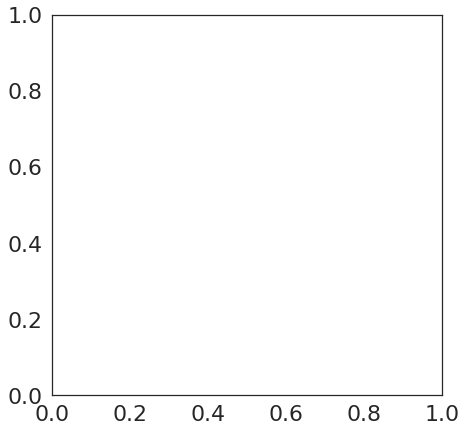

In [4]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

p_df = melted_df[melted_df['packet_size'] == 64]

fig1 = sns.pointplot(
    data=p_df[p_df['nworkers'] == 1],
    x="ST",
    y=p_df["value"] / (10**6),
    units="units",
    hue='VNF',
    ax=ax1,
    # palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    label="Measured",
    hue_order = ["L2XC", "L3FWD"],
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="",
    ylim=[-2, 26],
    title = 'Forwarding thread'
)
plt.setp(fig.lines, linewidth=1.25)
ax1.legend(title='VNF', loc='lower left')

sns.despine()
# fig.savefig("../output_figures/ndr_bypass_single_instance_single_thread.pdf")

fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(7, 7))

fig2 = sns.pointplot(
    data=p_df[p_df['nworkers'] == 2],
    x="ST",
    y=p_df["value"] / (10**6),
    units="units",
    hue='VNF',
    ax=ax2,
    # palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    label="Measured",
    hue_order = ["L2XC", "L3FWD"],
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="",
    ylim=[-2, 26],
    title = 'Forwarding + Egress thread'
)
plt.setp(fig.lines, linewidth=1.25)
plt.legend(title='VNF', loc='lower left')

sns.despine()
# fig.savefig("../output_figures/ndr_bypass_single_instance_two_thread.pdf")

- Adjust the Desc
- Run the same experiment without the HQoS thread, standard VPP 23.10

```set int mac address dev0 00:00:00:01:00:01
set int mac address dev1 00:00:00:01:00:02
set int mac address dev2 00:00:00:01:00:02
set int mac address dev3 00:00:00:01:00:03

set interface mtu 9000 dev0
set interface mtu 9000 dev1

set interface l2 xconnect dev0 dev1
set interface l2 xconnect dev1 dev0

set interface l2 xconnect dev2 dev3
set interface l2 xconnect dev3 dev2

set interface promiscuous off dev1
set interface promiscuous off dev3

set interface state dev0 up
set interface state dev1 up
set interface state dev2 up
set interface state dev3 up

set interface rx-placement dev1 worker 0
set interface rx-placement dev2 worker 1
```

```
8: enp134s0f0: <BROADCAST,MULTICAST,UP,LOWER_UP> mtu 1500 qdisc mq state UP mode DEFAULT group default qlen 1000
    link/ether 40:a6:b7:0a:7f:18 brd ff:ff:ff:ff:ff:ff
    vf 0     link/ether 00:00:00:01:00:01 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 1     link/ether 00:00:00:01:00:02 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 2     link/ether 00:00:00:01:00:02 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 3     link/ether 00:00:00:01:00:03 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 4     link/ether 56:d7:48:ab:28:4d brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 5     link/ether 96:51:14:d4:e7:93 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 6     link/ether 12:c9:27:fb:39:45 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 7     link/ether f2:a8:44:71:f4:3c brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 8     link/ether c6:71:cc:d3:ec:d4 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 9     link/ether a2:0f:d6:44:a7:79 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 10     link/ether 1a:b1:54:53:9a:4b brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 11     link/ether 6a:3c:1b:ad:1b:be brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
    vf 12     link/ether da:90:04:23:eb:78 brd ff:ff:ff:ff:ff:ff, spoof checking off, link-state auto, trust on
```

```
dpdk {
  no-multi-seg
  no-tx-checksum-offload

  dev default {
    num-rx-desc 4096
    num-tx-desc 4096
    num-rx-queues 1
  }
  dev 0000:86:01.0 {
    name dev0
  }
  dev 0000:86:01.1 {
    name dev1
    hqos {}
  }

  dev 0000:86:01.2 {
    name dev2 
  }
  dev 0000:86:01.3 {
    name dev3
    hqos {} 
  }
}
```

In [122]:
single_df.groupby(['packet_size', 'disabled'])['total_rx_pps'].describe()/(10**6)

count       mean       std        min        25%  \
packet_size disabled                                                        
64          bypass    0.000003  12.810601  0.027931  12.787612  12.795058   
            disabled  0.000003  15.886568  0.641635  15.146242  15.688893   
256         bypass    0.000003  12.735270  0.024704  12.706795  12.727416   
512         bypass    0.000003  12.788930  0.108662  12.665938  12.747433   
1500        bypass    0.000003   8.032256  0.024075   8.005780   8.021967   

                            50%        75%        max  
packet_size disabled                                   
64          bypass    12.802505  12.822095  12.841685  
            disabled  16.231544  16.256730  16.281917  
256         bypass    12.748037  12.749508  12.750979  
512         bypass    12.828928  12.850426  12.871924  
1500        bypass     8.038154   8.045493   8.052833

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

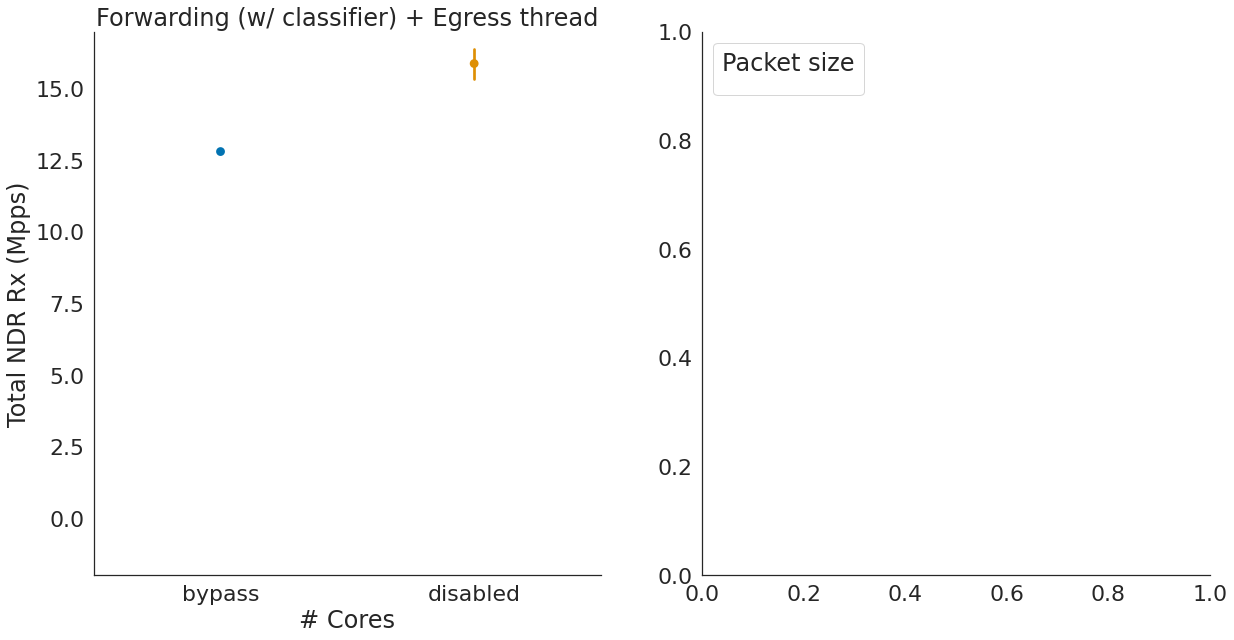

In [123]:
%matplotlib inline
#fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

p_df = single_df[single_df['ST'] == 'ST']
p_df = p_df[p_df['VNF'] == 'L2XC']
p_df = p_df.astype({'nworkers': int})

fig1 = sns.pointplot(
    data=p_df[p_df['packet_size'] == 64],
    x="disabled",
    y=p_df["total_rx_pps"] / (10**6),
    units="units",
    #ue='disabled',
    ax=ax1,
    palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    #label="Measured",
)

ax1.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="# Cores",
    ylim=[-2, 17],
    title = 'Forwarding (w/ classifier) + Egress thread'
)
plt.setp(fig.lines, linewidth=1.25)
plt.legend(title='Packet size', loc='upper left')

sns.despine()

p_df = single_df[single_df['ST'] == 'SMT']
p_df = p_df[p_df['VNF'] == 'L2XC']
p_df = p_df.astype({'nworkers': int})

fig2 = sns.pointplot(
    data=p_df,
    x="nworkers",
    y=p_df["total_rx_pps"] / (10**6),
    units="units",
    hue='packet_size',
    ax=ax2,
    palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    # label="Measured",
    #hue_order = ["L2XC", "L3FWD"],
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="# Cores",
    ylim=[-2, 50],
    title = 'Forwarding (w/ classifier) + Egress thread\nSMT Sibling cores'
) 
plt.setp(fig.lines, linewidth=1.25)
plt.legend(title='Packet size', loc='upper left')

sns.despine()

# fig.savefig("../output_figures/ndr_bypass_multicore_st.pdf")

In [99]:
%matplotlib inline
fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(10,10))

p_df = single_df[single_df['ST'] == 'SMT']
p_df = p_df[p_df['VNF'] == 'L2XC']
p_df = p_df.astype({'nworkers': int})

fig2 = sns.swarmplot(
    data=p_df,
    x="nworkers",
    y=p_df["total_rx_pps"] / (10**6),
    #units="units",
    hue='packet_size',
    ax=ax2,
    palette = 'colorblind',
    #ci='sd',
    #err_style="bars",
    #markersize=1,
    #errorwidth=3,
    #join=False,
    linestyles="--",
    linewidth=0.005,
    #hue_order = ["L2XC", "L3FWD"],
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="# Cores",
    ylim=[-2, 50],
    title = 'Forwarding + Egress thread\nSMT Sibling cores'
)
plt.setp(fig.lines, linewidth=1.25)
plt.legend(title='Packet size', loc='upper left')

sns.despine()
# fig.savefig("../output_figures/ndr_bypass_smt_two_thread.pdf")

# 4 Multicore 

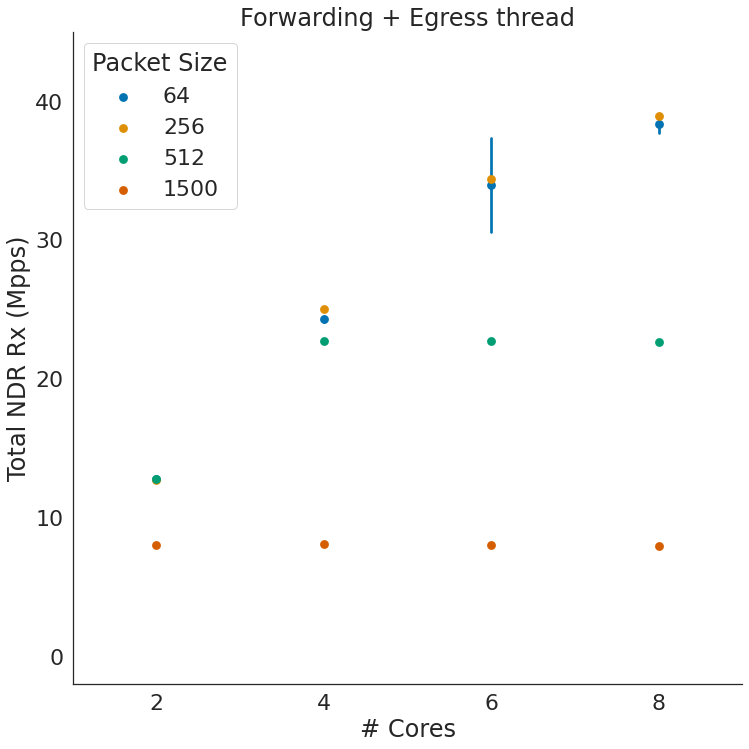

In [6]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,12))

p_df = single_df[single_df['ST'] == 'ST']
p_df = p_df[p_df['VNF'] == 'L2XC']
p_df = p_df.astype({'nworkers': int}).loc[p_df['nworkers'].isin([2,4,6,8])]

fig1 = sns.pointplot(
    data=p_df,
    x="nworkers",
    y=p_df["total_rx_pps"] / (10**6),
    units="units",
    hue='packet_size',
    ax=ax1,
    palette = 'colorblind',
    ci='sd',
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    label="Measured",
    #hue_order = [2, 4],
)

ax1.set(
    ylabel="Total NDR Rx (Mpps)",
    xlabel="# Cores",
    ylim=[-2, 45],
    title = 'Forwarding + Egress thread'
)
plt.setp(fig.lines, linewidth=1.25)
ax1.legend(title='Packet Size', loc='upper left')


sns.despine()
# fig.savefig("../output_figures/ndr_bypass_single_instance_single_thread.pdf")


In [119]:
experiment_labels = [
    "2200",
    # "8192-6gbpsl1",
]

measurements = list()

for experiment in experiment_labels:
    output_dir = f"../output/ndr-hqos-max-st-{experiment}"
    for direc, sub_direc, files in os.walk(output_dir):
        if "discarded" in direc:
            continue

        if files == []:
            continue

        if "old" in direc:
            continue

        t = dict()
        misses = 0
        drops = 0
        vectors = 0
        call = 0

        for file in files:
            none, flows, packet_size, repeat = direc.replace(output_dir, "").split("/")
                        
            if "average" in file:
                perfstat = pd.read_csv(direc + "/" + file, index_col = 'metrics')

            if "vpp" in file:
                with open(
                    direc + "/" + file, "r", encoding="utf8", errors="ignore"
                ) as f:
                    for line in f.readlines():
                        p = line.strip().split()
                        if (
                            "/interfaces/dev0/rx-miss" in p[-1]
                            and "0" in p[2]
                            and "0" in p[0]
                        ):
                            misses = int(p[3])
                            continue

                        m = re.search(r"\[0 @ 2\]: (\d*) packets \/err\/dev1-tx\/Tx packet drops.*", line)
                        if (m):
                            drops += int(m.group(1))
                            continue

                        if (
                            "/nodes/dev0-output/vectors" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            vectors = int(p[3])
                            continue

                        if (
                            "/nodes/dev0-output/calls" in p
                            and "2]:" in p[2]
                            and "[0" in p[0]
                        ):
                            calls = int(p[3])
                            continue

            if "trex" in file:
                with open(direc + "/" + file, "r") as f:
                    contents = f.read().replace("\n", "").replace("'", '"')
                    try:
                        t = json.loads(contents)
                    except SyntaxError:
                        print(direc + "/" + files[0])
                        continue


        metric = 'p95'
        total_errors = misses + drops
        measurements.append(
            {
                "total_rx_L1": t["results"]["total_tx_L1"],
                "total_tx_L1": int(t["results"]["total_rx_L1"]),
                "total_tx_pps": int(t["results"]["tx_pps"]),
                "total_rx_pps": int(t["results"]["rx_pps"]),
                #"VNF": label,
                'ST': 'SMT' if 'ht' in experiment else 'ST',
                'nworkers': 2,
                "packet_size": int(packet_size),
                "misses": misses,
                'flows': int(flows),
                "drops": drops,
                "misses_normalized": misses
                / (1 if total_errors == 0 else total_errors)
                * 100,
                "drops_normalized": drops
                / (1 if total_errors == 0 else total_errors)
                * 100,
                #"no_buf": no_buf,
                "total_errors": total_errors,
                "units": repeat,
                "vectors": vectors,
                
                'IPC': perfstat.loc['metric_kernel_CPI', metric],
                'Frontend Bound': perfstat.loc['metric_TMA_Frontend_Bound(%)',metric],
                'Backend Bound': perfstat.loc['metric_TMA_Backend_Bound(%)', metric],
                'Cache Bound': perfstat.loc['metric_TMA_..Memory_Bound(%)', metric],
                'Core Bound': perfstat.loc['metric_TMA_..Core_Bound(%)', metric],
                'Memory Bound': perfstat.loc['metric_TMA_....MEM_Bound(%)', metric],
                'DTLB load miss': perfstat.loc['metric_DTLB load miss latency (in core clks)', metric],
                
                'L1 Bound': perfstat.loc['metric_TMA_....L1_Bound(%)', metric],
                'L2 Bound': perfstat.loc['metric_TMA_....L2_Bound(%)', metric],
                'L3 Bound': perfstat.loc['metric_TMA_....L3_Bound(%)',metric],
        
              #"vector_rate": vector_rate,
                #"call": calls,
            }
        )
    hqosmax_df = pd.DataFrame(measurements)

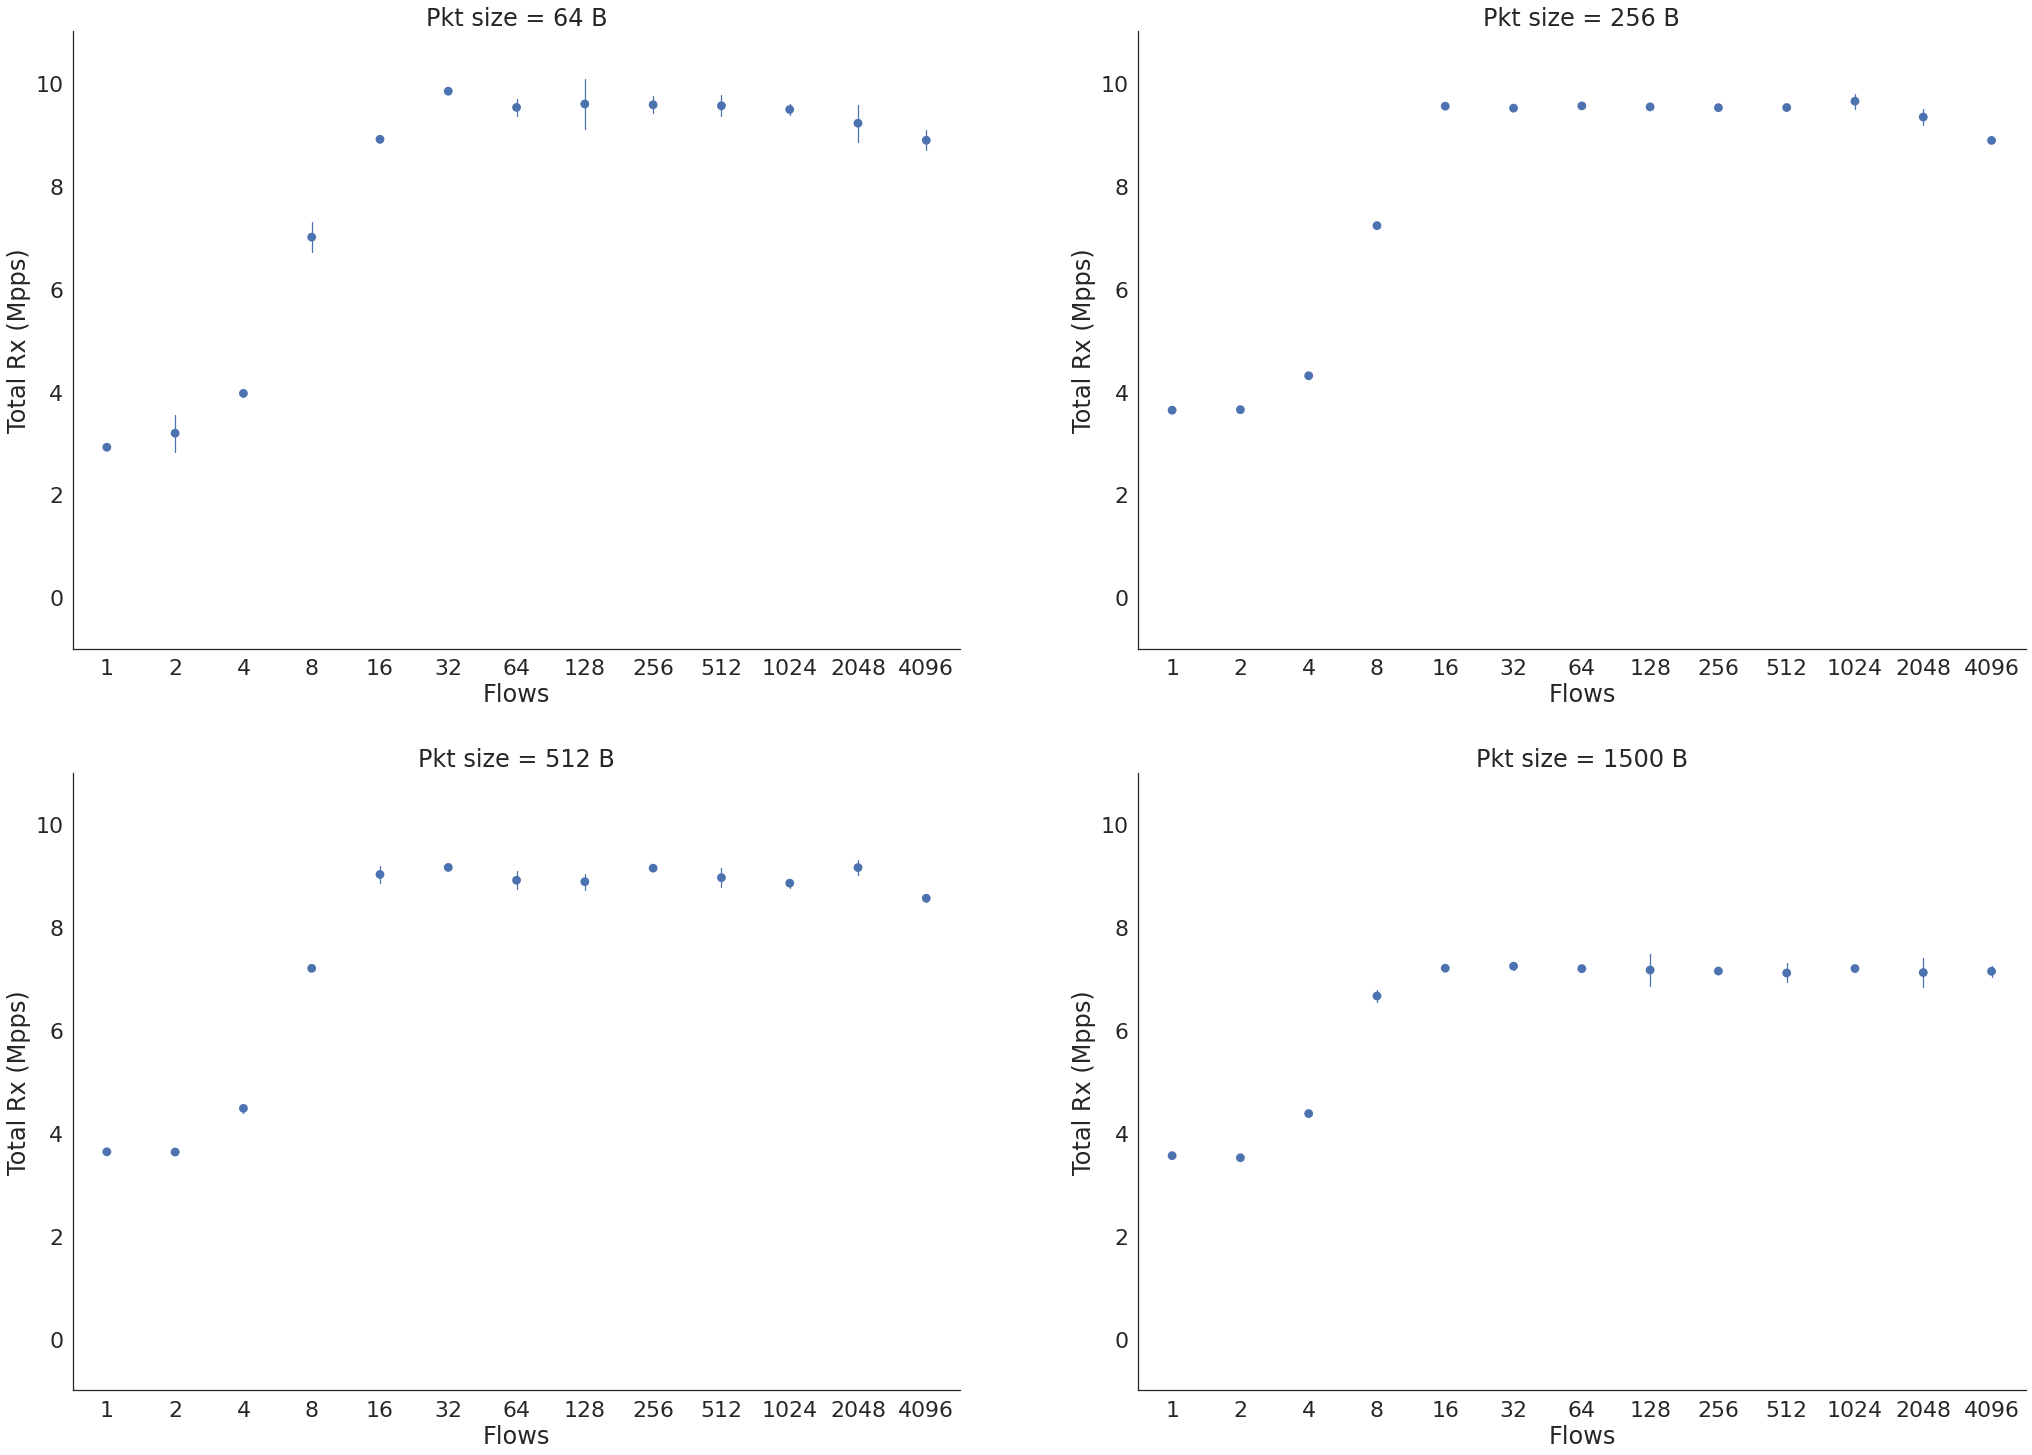

In [120]:
# %#matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 25))

fig = sns.pointplot(
    data=hqosmax_df[hqosmax_df["packet_size"] == 64],
    x="flows",
    y=hqosmax_df["total_rx_pps"] / (10**6),
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
    # hue="packet_size",
    units="units",
    ax=ax1,
    # palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Flows",
    title="Pkt size = 64 B",
    ylim=[-1, 11],
)
plt.setp(fig.lines, linewidth=1.25)
# plt.legend(title = "Total offered load")

fig = sns.pointplot(
    data=hqosmax_df[hqosmax_df["packet_size"] == 256],
    x="flows",
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
    y=hqosmax_df["total_rx_pps"] / (10**6),
    # hue="Offered load",
    units="units",
    ax=ax2,
    # palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Flows",
    title="Pkt size = 256 B",
    ylim=[-1, 11],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=hqosmax_df[hqosmax_df["packet_size"] == 512],
    x="flows",
    y=hqosmax_df["total_rx_pps"] / (10**6),
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
    # hue="Offered load",
    units="units",
    ax=ax3,
    # palette="colorblind",
    ci="sd",
    err_style="bars",
    # dodge = 0.5,
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500]g = sns.factorplot(x="time", y="pulse", hue="kind", data=exercise, scale=.5)
)

ax3.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Flows",
    title="Pkt size = 512 B",
    ylim=[-1, 11],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=hqosmax_df[hqosmax_df["packet_size"] == 1500],
    x="flows",
    y=hqosmax_df["total_rx_pps"] / (10**6),
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
    # hue="Offered load",
    units="units",
    ax=ax4,
    # palette="colorblind",
    ci="sd",
    err_style="bars",
    # dodge = 0.5,
    markersize=1,
    errorwidth=3,
    join=False,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500]
)

ax4.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Flows",
    title="Pkt size = 1500 B",
    ylim=[-1, 11],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

# fig.get_figure().savefig("mc_rx_load_pkt_size_2200_bps.png")

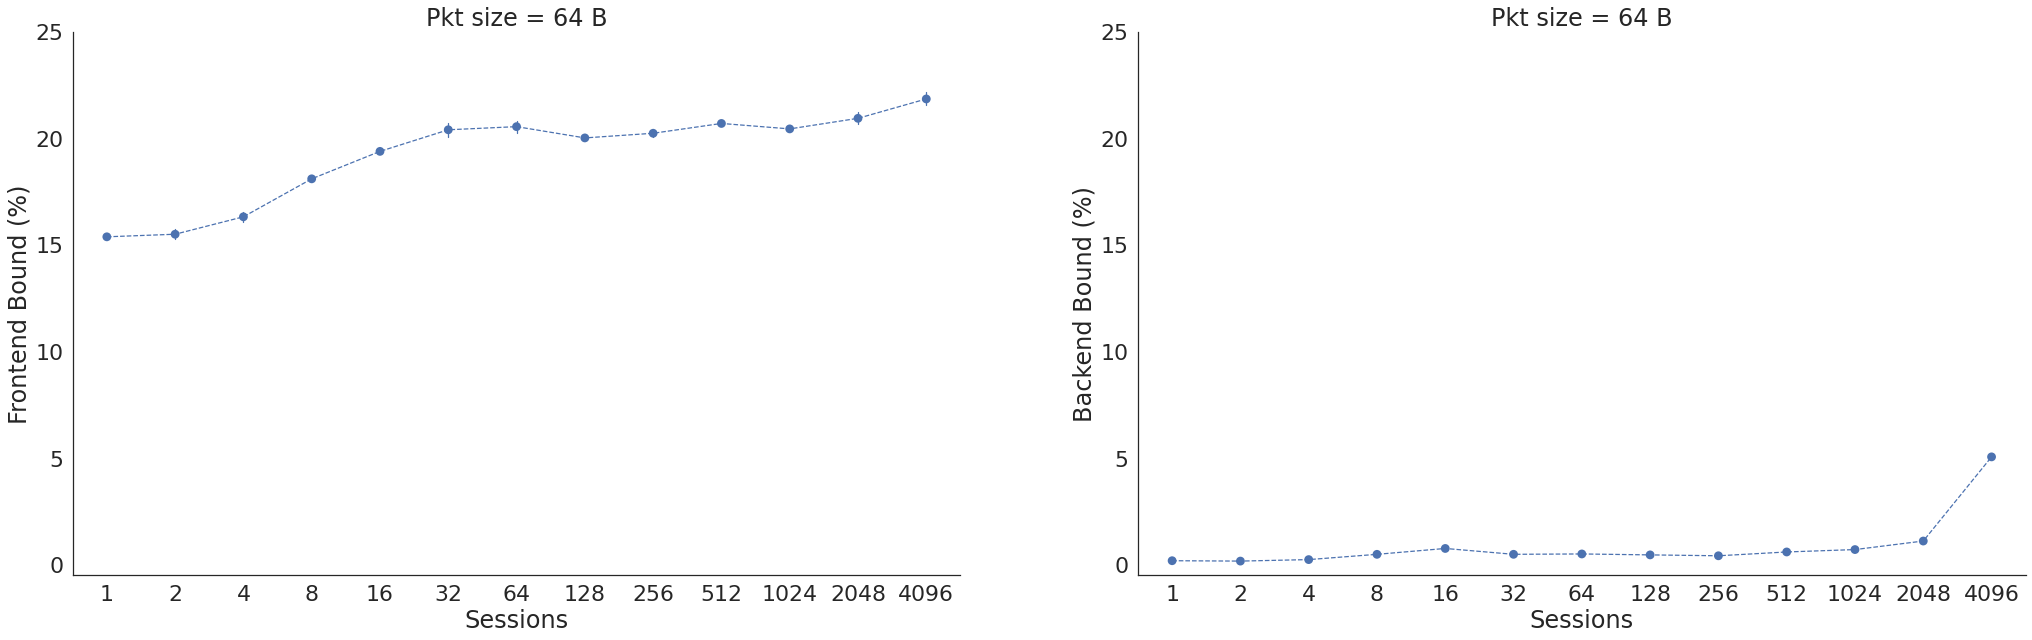

In [100]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(35, 10))

fig = sns.pointplot(
    data=hqosmax_df[hqosmax_df["packet_size"] == 64],
    x="flows",
    y='Core Bound',
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
    #hue="packet_size",
    units="units",
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Frontend Bound (%)",
    xlabel="Sessions",
    title="Pkt size = 64 B",
    ylim = [-0.5, 25],
)
plt.setp(fig.lines, linewidth=1.25)
# plt.legend(title = "Total offered load")

fig = sns.pointplot(
    data=hqosmax_df[hqosmax_df["packet_size"] == 64],
    x="flows",
    y='Memory Bound',
    #hue="Offered load",
    units="units",
    ax=ax2,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Backend Bound (%)",
    xlabel="Sessions",
    title="Pkt size = 64 B",
    ylim = [-0.5, 25],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

# fig.get_figure().savefig("mc_rx_load_pkt_size_2200_bps.png")

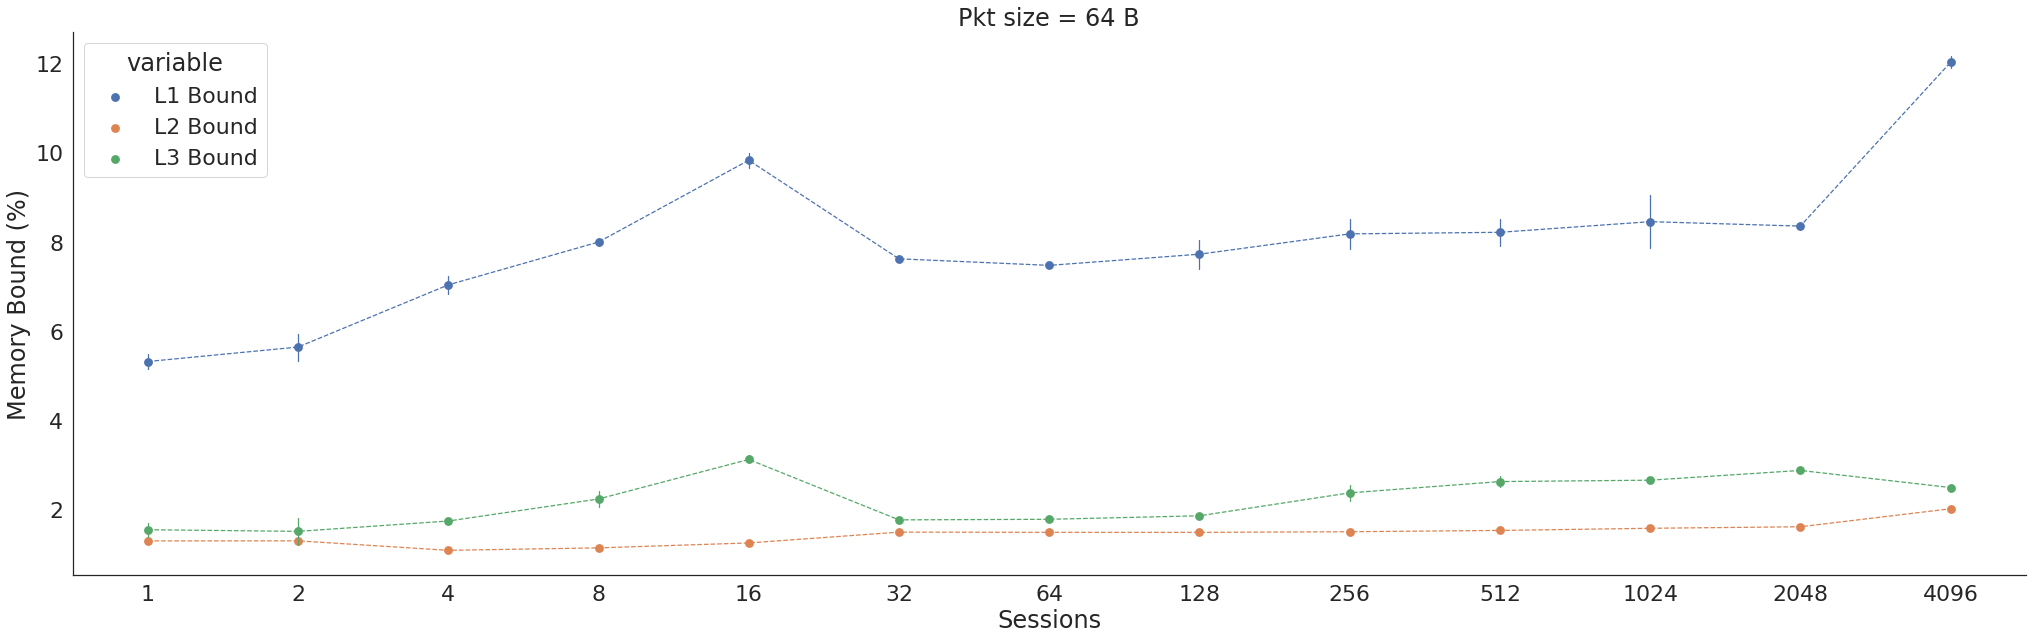

In [101]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(35, 10))

p_df = pd.melt(
    hqosmax_df[hqosmax_df['packet_size'] == 64],
    id_vars = ['flows', 'units'],
    value_vars = ['L1 Bound', 'L2 Bound', 'L3 Bound']
)

fig = sns.pointplot(
    data=p_df,
    x="flows",
    y='value',
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="variable",
    units="units",
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Memory Bound (%)",
    xlabel="Sessions",
    title="Pkt size = 64 B",
    #ylim = [-0.5, 25],
)
plt.setp(fig.lines, linewidth=1.25)
# plt.legend(title = "Total offered load")

sns.despine()

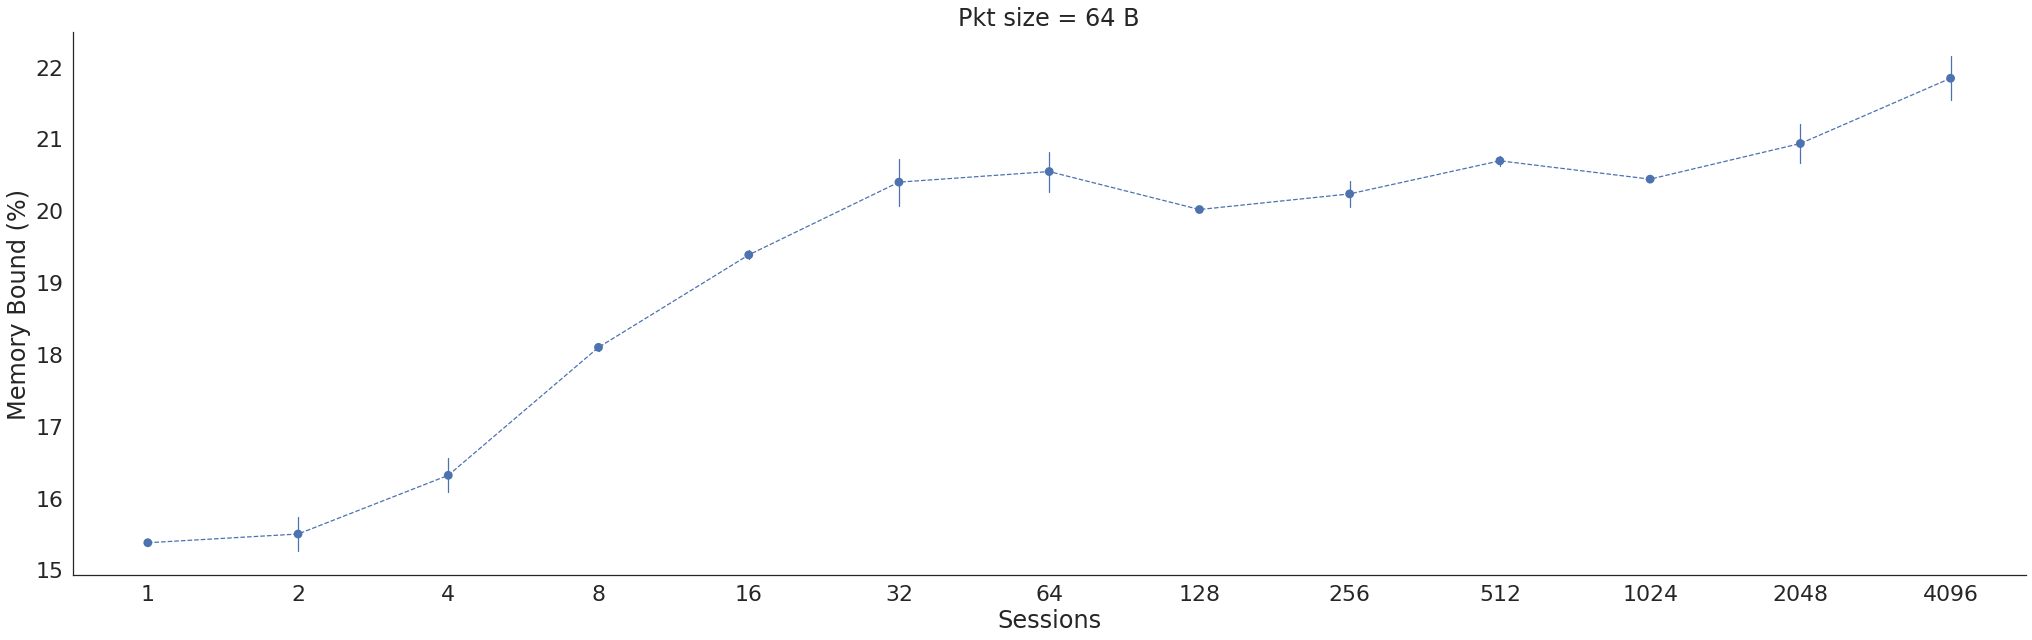

In [103]:
%matplotlib inline
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(35, 10))

fig = sns.pointplot(
    data = hqosmax_df[hqosmax_df['packet_size'] == 64],
    x="flows",
    y='Core Bound',
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
   # hue="variable",
    units="units",
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Memory Bound (%)",
    xlabel="Sessions",
    title="Pkt size = 64 B",
    #ylim = [-0.5, 25],
)
plt.setp(fig.lines, linewidth=1.25)
# plt.legend(title = "Total offered load")

sns.despine()

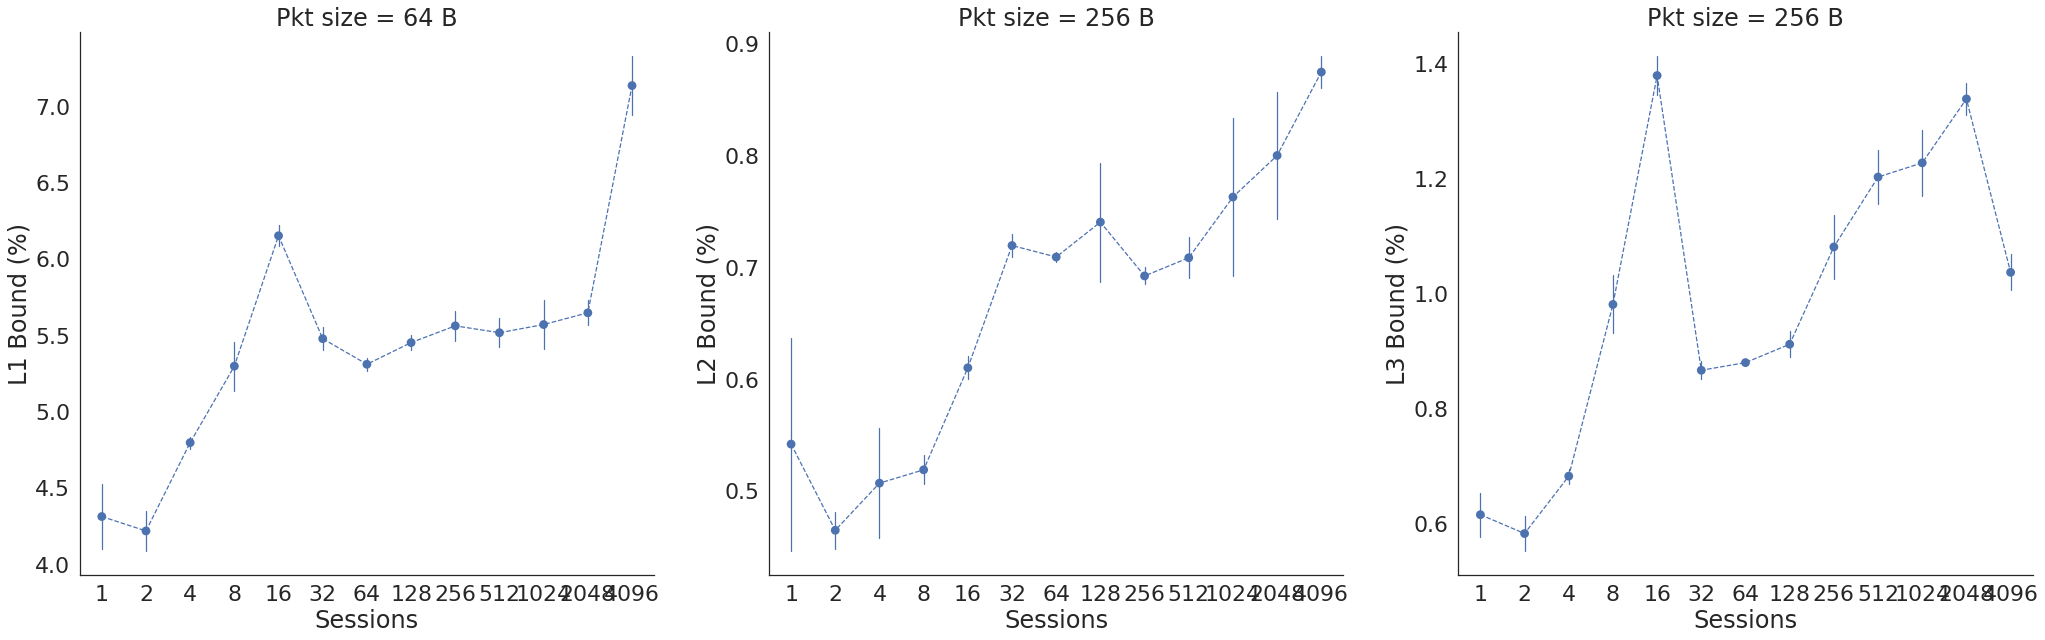

In [69]:
%matplotlib inline
fig, (ax1, ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(35, 10))

fig = sns.pointplot(
    data=hqosmax_df[hqosmax_df["packet_size"] == 64],
    x="flows",
    y='L1 Bound',
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
    #hue="packet_size",
    units="units",
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="L1 Bound (%)",
    xlabel="Sessions",
    title="Pkt size = 64 B",
    #ylim = [-0.5, 25],
)
plt.setp(fig.lines, linewidth=1.25)
# plt.legend(title = "Total offered load")

fig = sns.pointplot(
    data=hqosmax_df[hqosmax_df["packet_size"] == 64],
    x="flows",
    y='L2 Bound',
    #hue="Offered load",
    units="units",
    ax=ax2,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="L2 Bound (%)",
    xlabel="Sessions",
    title="Pkt size = 256 B",
    #ylim = [-0.5, 25],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=hqosmax_df[hqosmax_df["packet_size"] == 64],
    x="flows",
    y='L3 Bound',
    #hue="Offered load",
    units="units",
    ax=ax3,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="L3 Bound (%)",
    xlabel="Sessions",
    title="Pkt size = 256 B",
    #ylim = [-0.5, 25],
)
plt.setp(fig.lines, linewidth=1.25)


sns.despine()

# fig.get_figure().savefig("mc_rx_load_pkt_size_2200_bps.png")

In [36]:
t_df = hqosmax_df
columns = ["misses_normalized", "drops_normalized"]
error_df = pd.melt(
    t_df,
    id_vars=[
        "units",
        #"experiment_int",
        "packet_size",
        "flows",
        #"tx_util",
        #"lost_packets",
        #"Offered load",
    ],
    value_vars=columns,
).rename(columns={"variable": "Error Type", "value": "Errors"})
#error_df = error_df.assign(
#    normalized_errors=error_df["Errors"] / error_df["lost_packets"] * 100
#).replace(to_replace=np.nan, value=0)

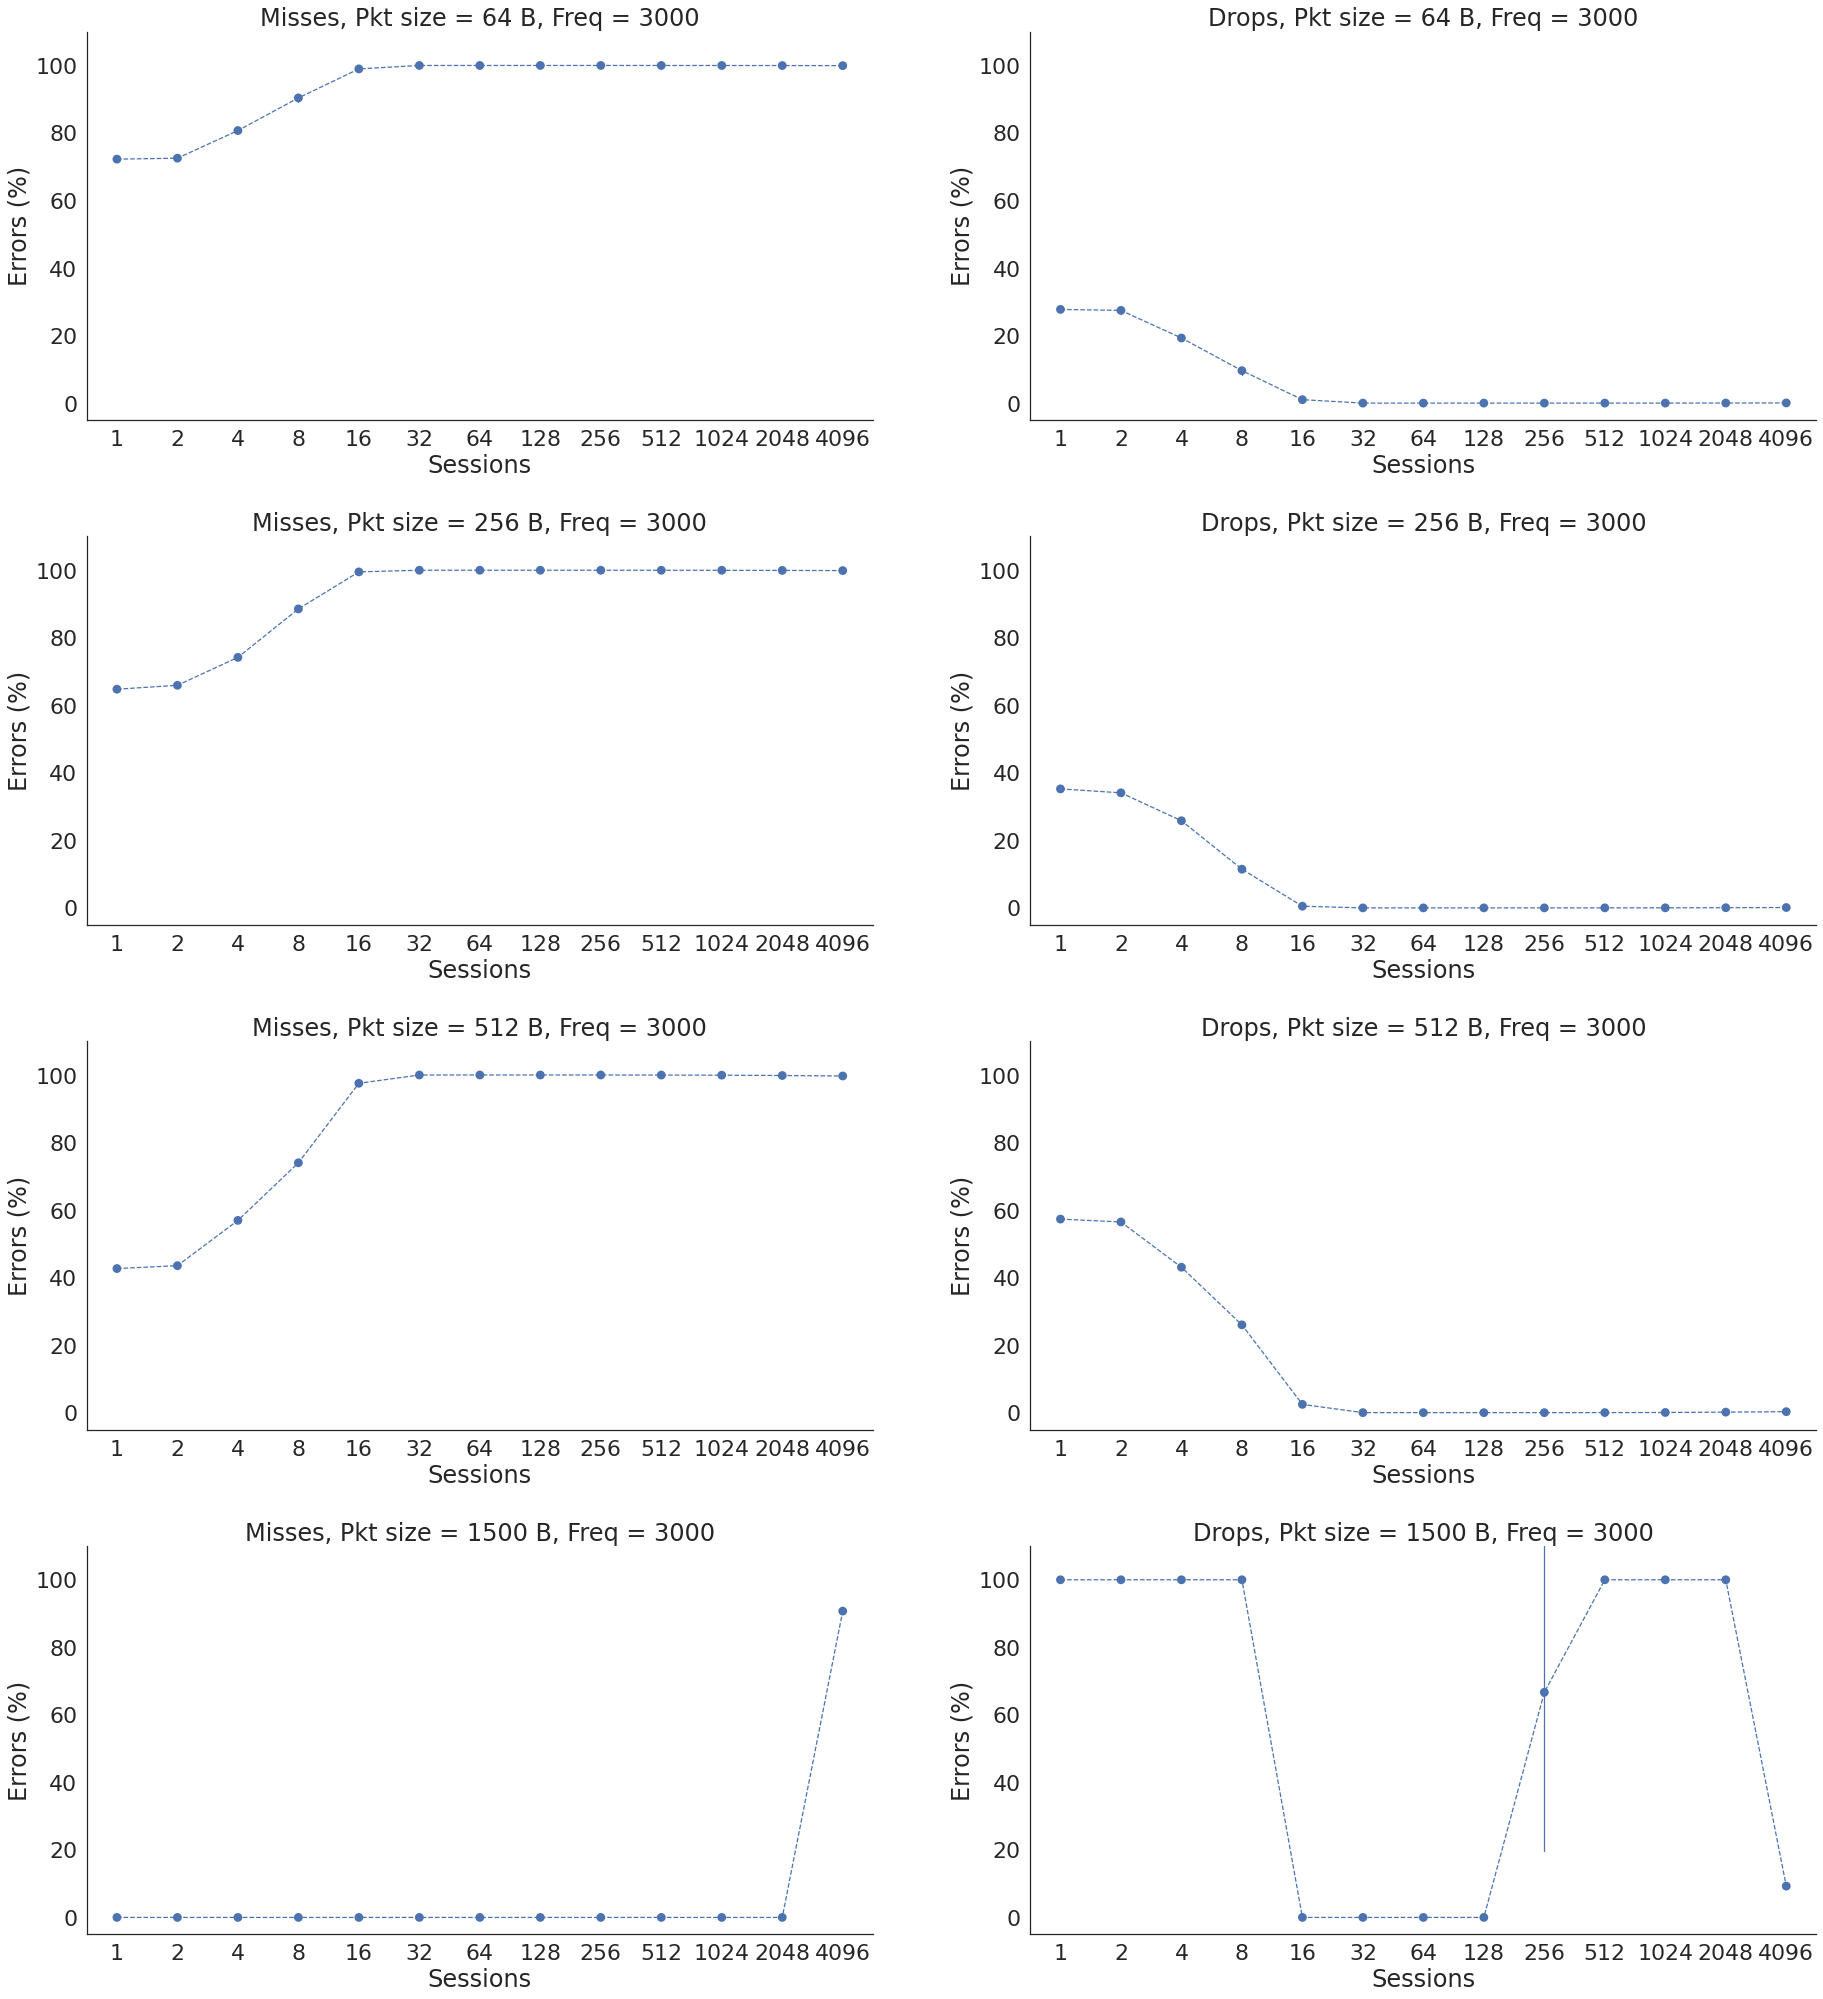

In [43]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(
    nrows=4, ncols=2, figsize=(31, 35)
)

FREQ = 3000

PKT_SIZE = 64
p_df = error_df[error_df["packet_size"] == PKT_SIZE]

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "misses_normalized"],
    x="flows",
    y=(p_df["Errors"]),
    units="units",
    ax=ax1,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax1.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Misses, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "drops_normalized"],
    x="flows",
    y=(p_df["Errors"]),
    units="units",
    ax=ax2,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax2.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Drops, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
    # ylim = [-0.1, 2],
)
plt.setp(fig.lines, linewidth=1.25)

PKT_SIZE = 256
p_df = error_df[error_df["packet_size"] == PKT_SIZE]

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "misses_normalized"],
    x="flows",
    y="Errors",
    units="units",
    ax=ax3,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax3.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Misses, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "drops_normalized"],
    x="flows",
    y="Errors",
    units="units",
    ax=ax4,
   # palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax4.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Drops, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
)
plt.setp(fig.lines, linewidth=1.25)

PKT_SIZE = 512
p_df = error_df[error_df["packet_size"] == PKT_SIZE]

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "misses_normalized"],
    x="flows",
    y="Errors",
    units="units",
    ax=ax5,
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax5.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Misses, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "drops_normalized"],
    x="flows",
    y="Errors",
    units="units",
    ax=ax6,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax6.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Drops, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
)
plt.setp(fig.lines, linewidth=1.25)

PKT_SIZE = 1500
p_df = error_df[error_df["packet_size"] == PKT_SIZE]

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "misses_normalized"],
    x="flows",
    y="Errors",
    units="units",
    ax=ax7,
    #palette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax7.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Misses, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
    # ylim = [-0.05, 1],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "drops_normalized"],
    x="flows",
    y="Errors",
    units="units",
    ax=ax8,
    #alette="colorblind",
    ci="sd",
    err_style="bars",
    join=True,
    markersize=1,
    errorwidth=3,
    linestyles="--",
)

ax8.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    ylim=[-5, 110],
    title=f"Drops, Pkt size = {PKT_SIZE} B, Freq = {FREQ}",
)
plt.setp(fig.lines, linewidth=1.25)

plt.subplots_adjust(hspace=0.3)

sns.despine()

# fig.get_figure().savefig(f"../output_figures/{FREQ}_misses_drops.pdf")

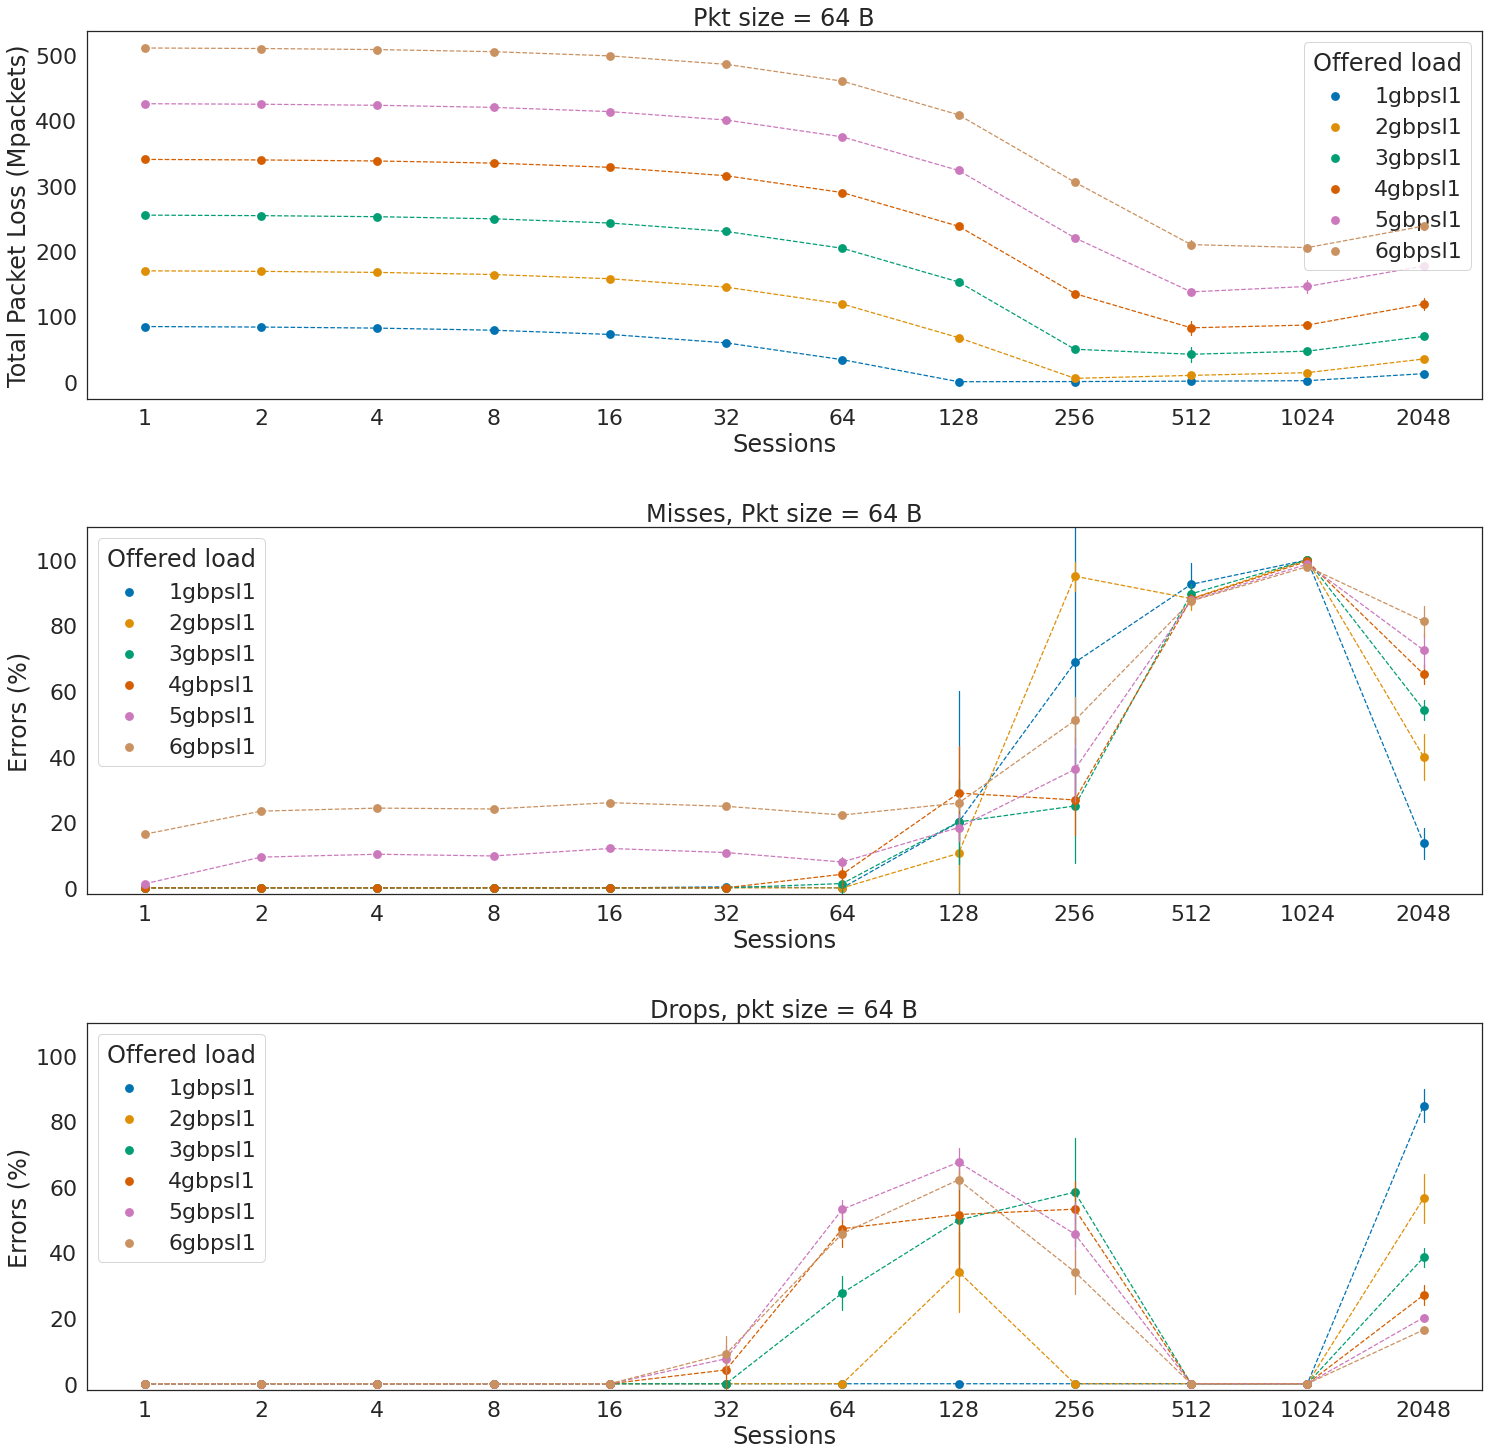

In [40]:
# %#matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(25, 25))

p_df = multicore_measures_df[multicore_measures_df["packet_size"] == 64]

fig = sns.pointplot(
    data=multicore_measures_df[multicore_measures_df["packet_size"] == 64],
    x="flows",
    y=multicore_measures_df["lost_packets"] / (10**6),
    hue="Offered load",
    units="units",
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Packet Loss (Mpackets)",
    xlabel="Sessions",
    title="Pkt size = 64 B",
)
plt.setp(fig.lines, linewidth=1.25)

p_df = multicore_error_df[multicore_error_df["packet_size"] == 64]

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "misses"],
    x="flows",
    y="normalized_errors",
    hue="Offered load",
    units="units",
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    title="Misses, Pkt size = 64 B",
    ylim=[-2, 110],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=p_df[p_df["Error Type"] == "drops"],
    x="flows",
    y="normalized_errors",
    hue="Offered load",
    units="units",
    ax=ax3,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax3.set(
    ylabel="Errors (%)",
    xlabel="Sessions",
    title="Drops, pkt size = 64 B",
    ylim=[-2, 110],
)
plt.setp(fig.lines, linewidth=1.25)

plt.subplots_adjust(hspace=0.35)

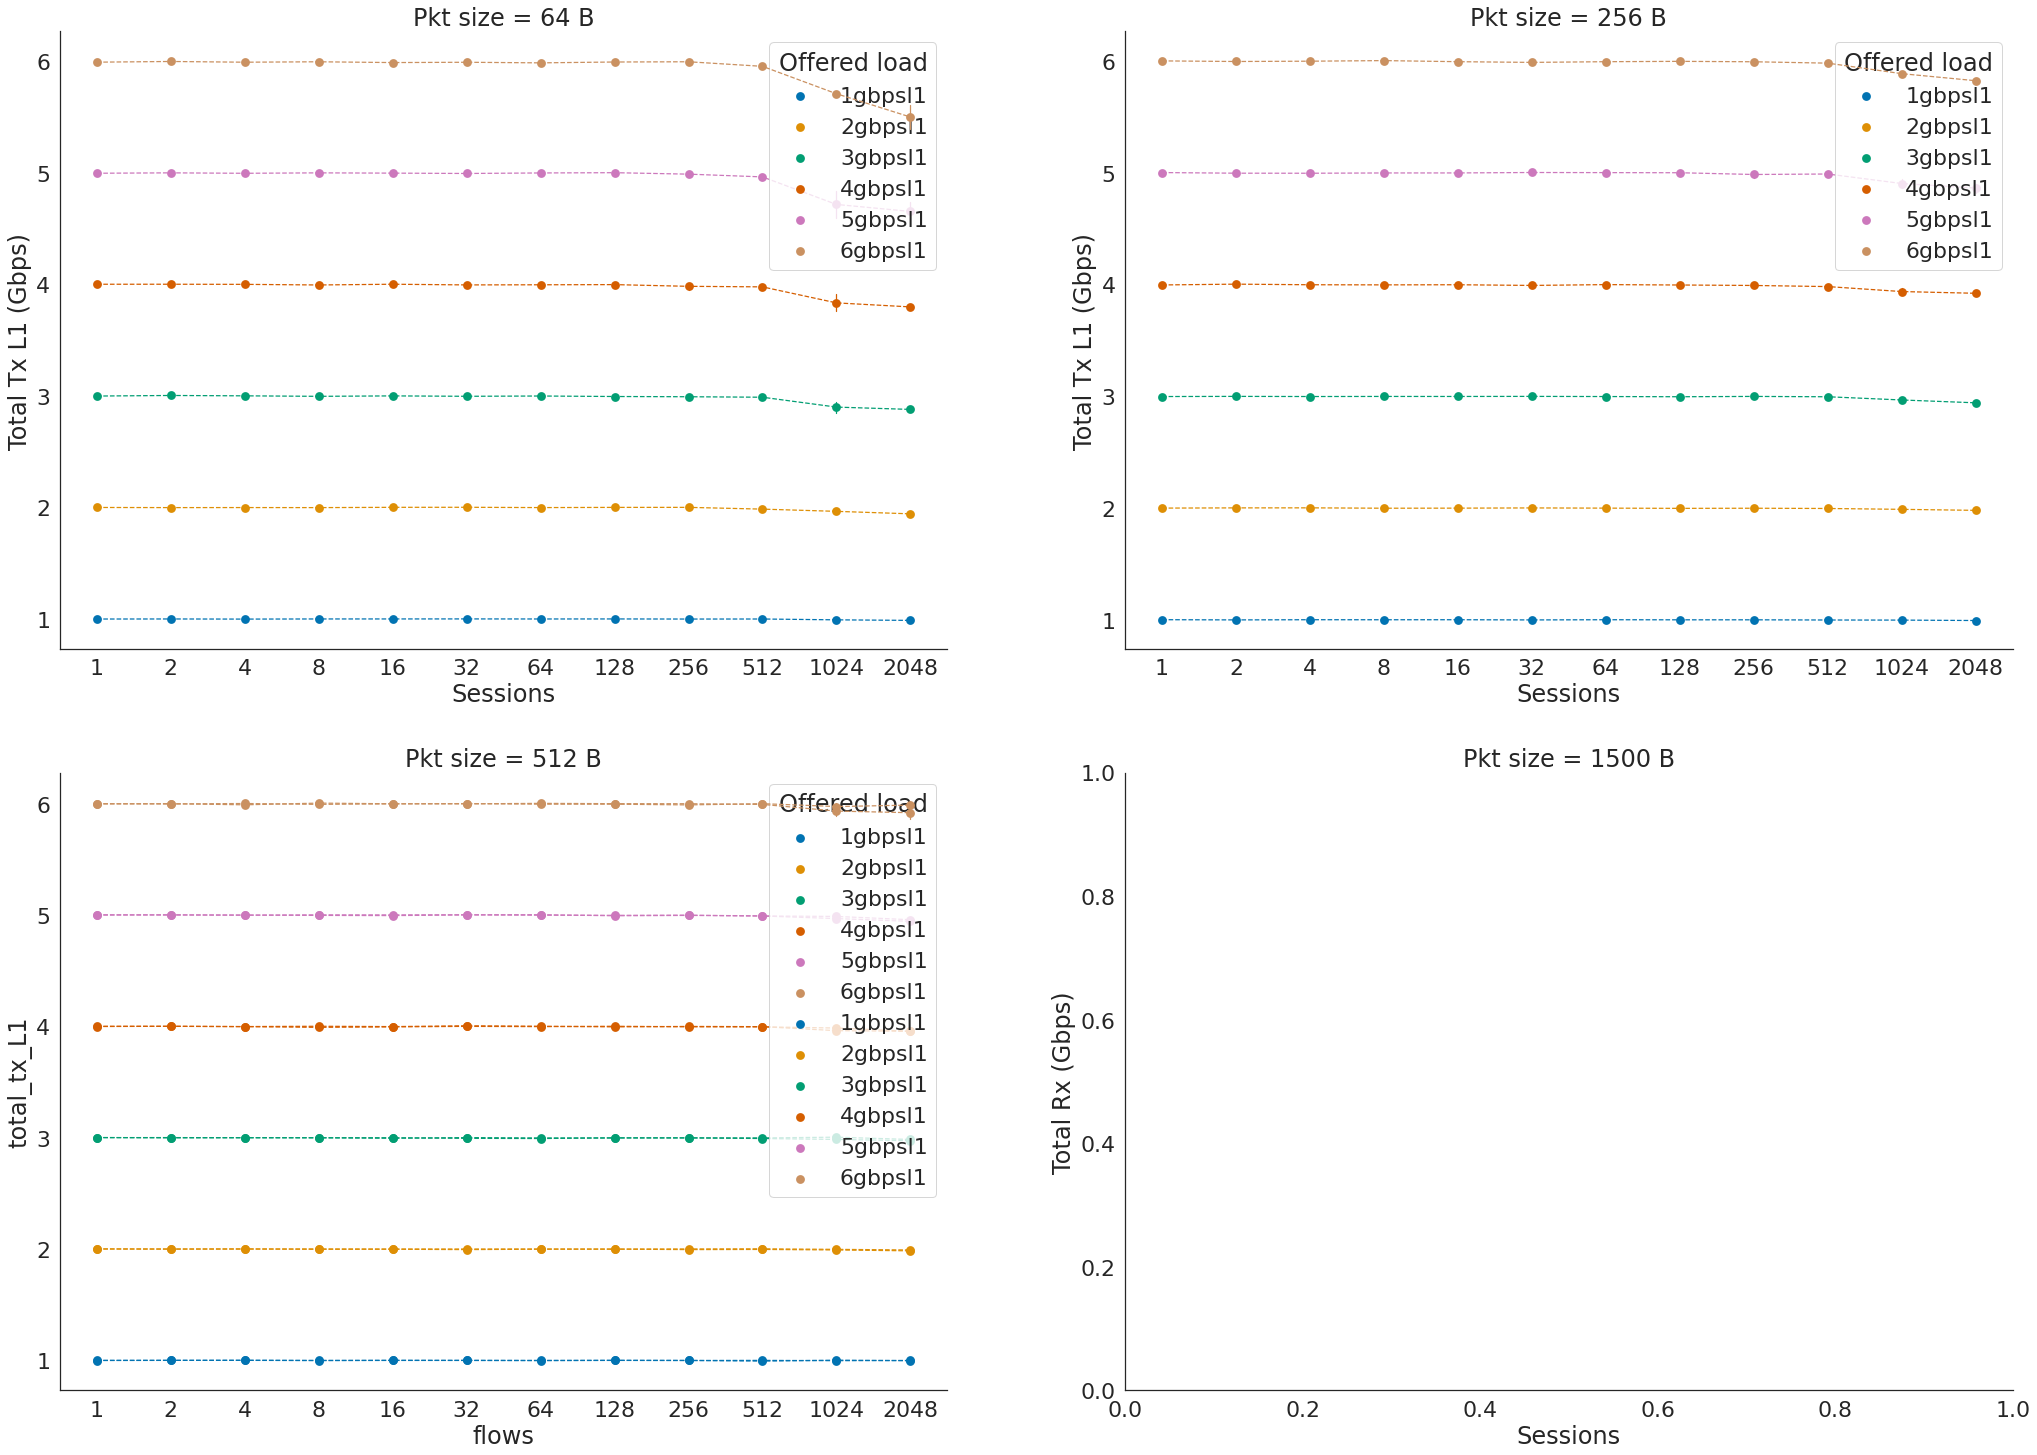

In [56]:
%matplotlib inline
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(35, 25))

fig = sns.pointplot(
    data=multicore_measures_df[multicore_measures_df["packet_size"] == 64],
    x="flows",
    y=multicore_measures_df["total_tx_L1"] / (10**9),
    hue="Offered load",
    units="units",
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Tx L1 (Gbps)",
    xlabel="Sessions",
    title="Pkt size = 64 B",
)
plt.setp(fig.lines, linewidth=1.25)
# plt.legend(title = "Total offered load")


fig = sns.pointplot(
    data=multicore_measures_df[multicore_measures_df["packet_size"] == 256],
    x="flows",
    y=multicore_measures_df["total_tx_L1"] / (10**9),
    hue="Offered load",
    units="units",
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Total Tx L1 (Gbps)",
    xlabel="Sessions",
    title="Pkt size = 256 B",
    # ylim = [-0.1, 3],
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=multicore_measures_df[multicore_measures_df["packet_size"] == 512],
    x="flows",
    y=multicore_measures_df["total_tx_L1"] / (10**9),
    hue="Offered load",
    units="units",
    ax=ax3,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    # dodge = 0.5,
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500]g = sns.factorplot(x="time", y="pulse", hue="kind", data=exercise, scale=.5)
)

ax3.set(
    ylabel="Total Tx L1 (Gbps)",
    xlabel="Sessions",
    title="Pkt size = 512 B",
)
plt.setp(fig.lines, linewidth=1.25)

fig = sns.pointplot(
    data=multicore_measures_df[multicore_measures_df["packet_size"] == 1500],
    x="flows",
    y=multicore_measures_df["total_tx_L1"] / (10**9),
    hue="Offered load",
    units="units",
    ax=ax3,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    # dodge = 0.5,
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500]
)


ax4.set(
    ylabel="Total Rx (Gbps)",
    xlabel="Sessions",
    title="Pkt size = 1500 B",
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

# fig.get_figure().savefig("rx_load_pkt_size_2200_bps.png")

# comparative 

NameError: name 'measures_df' is not defined

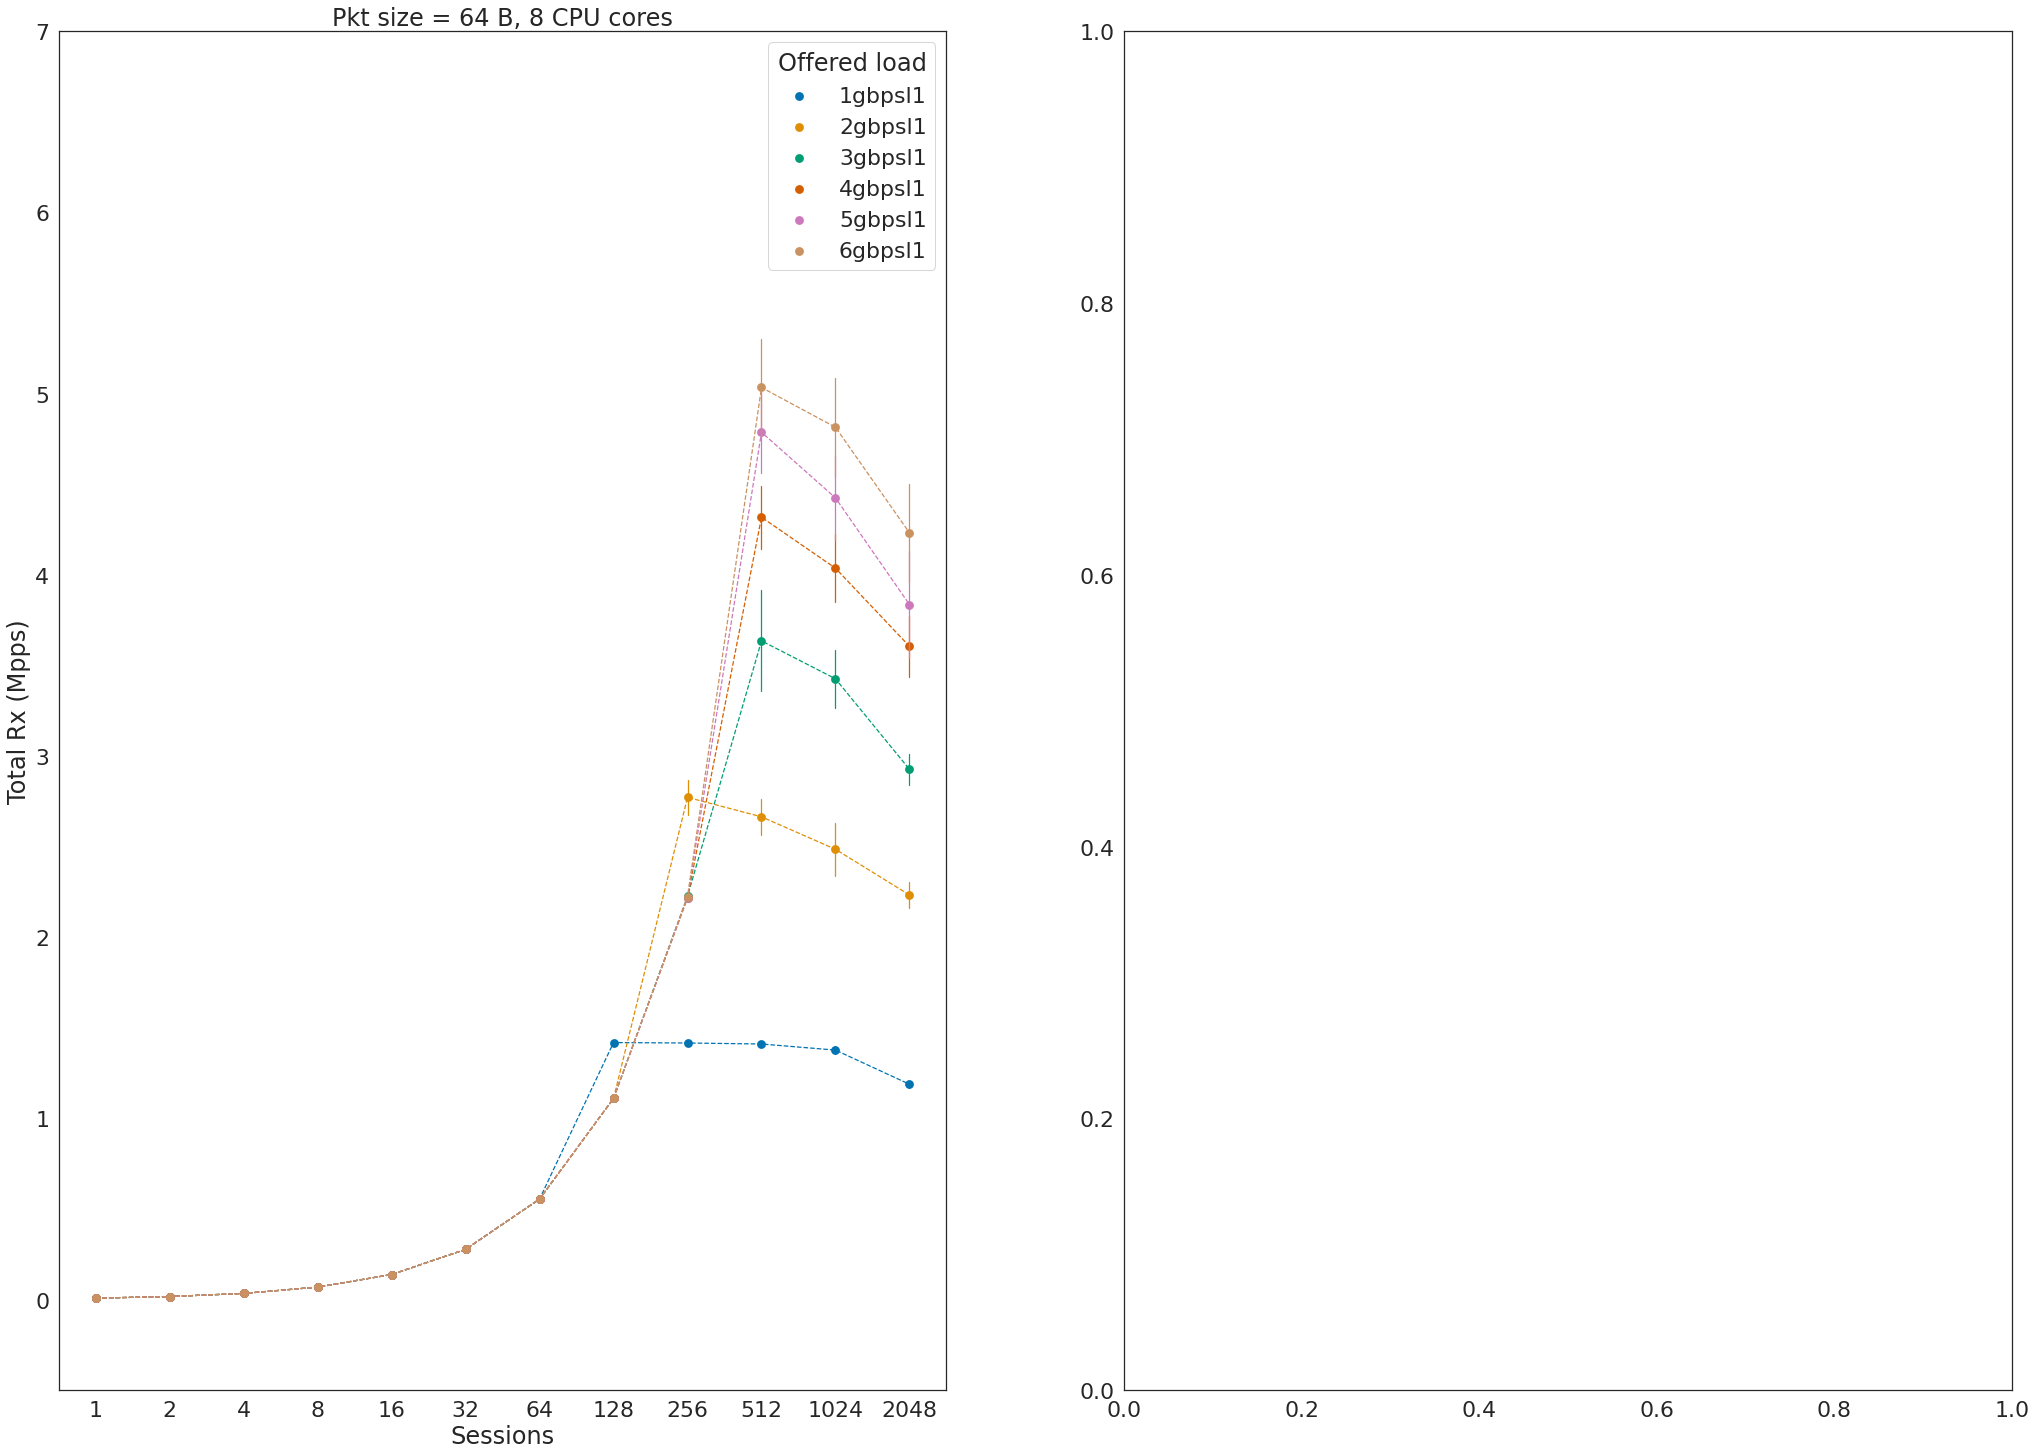

In [42]:
%matplotlib inline
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(35, 25))

fig = sns.pointplot(
    data=multicore_measures_df[multicore_measures_df["packet_size"] == 64],
    x="flows",
    y=multicore_measures_df["total_rx_pps"] / (10**6),
    # y=multicore_measures_df["total_rx_L1"] / (10**9),
    hue="Offered load",
    units="units",
    ax=ax1,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    linewidth=0.005,
    # hue_order = [64, 256, 512, 1500],
)

ax1.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Sessions",
    title="Pkt size = 64 B, 8 CPU cores",
    ylim = [-0.5, 7],
)
plt.setp(fig.lines, linewidth=1.25)
# plt.legend(title = "Total offered load")

fig = sns.pointplot(
    data=measures_df[measures_df["packet_size"] == 64],
    x="flows",
    #y=multicore_measures_df["total_rx_L1"] / (10**9),
    y=measures_df["total_rx_pps"] / (10**6),
    hue="Offered load",
    units="units",
    ax=ax2,
    palette="colorblind",
    ci="sd",
    err_style="bars",
    markersize=1,
    errorwidth=3,
    join=True,
    linestyles="--",
    # hue_order = [64, 256, 512, 1500],
)

ax2.set(
    ylabel="Total Rx (Mpps)",
    xlabel="Sessions",
    title="Pkt size = 64 B, CPU cores = 1",
    ylim = [-0.5, 7],
)
plt.setp(fig.lines, linewidth=1.25)

sns.despine()

# fig.get_figure().savefig("comparative.png")

Next 2544 tests:
vanilla VPP 23.10, no HQoS thread
L2 xconnect

- Setup 1: 
    - Same VF hairpin
- Setup 2:
    - Different VF

Next 2544 tests:
vanilla VPP 23.10, HQoS thread
L2 xconnect

- Setup 3: 
    - Same VF hairpin
- Setup 4:
    - Different VF